# **Project Name**    - Credit Card Default Prediction

 **Project Type**    - Binary Classification

 This script contains a comprehensive analysis for predicting credit card defaults using a binary classification approach. It includes exploratory data analysis, feature engineering, model training, and evaluation.


 **data**    - https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset


## Features Description

This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005. There are 25 features in the dataset:

* **ID**: ID of each client

* **LIMIT_BAL**: Amount of given credit in NT dollars (includes individual and family/supplementary credit)

* **SEX**: Gender (1=male, 2=female)

* **EDUCATION**: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)

* **MARRIAGE**: Marital status (1=married, 2=single, 3=others)

* **AGE**: Age in years

* **PAY_0**: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, 8=payment delay for eight months, 9=payment delay for nine months and above)

* **PAY_2**: Repayment status in August, 2005 (scale same as above)

* **PAY_3**: Repayment status in July, 2005 (scale same as above)

* **PAY_4**: Repayment status in June, 2005 (scale same as above)

* **PAY_5**: Repayment status in May, 2005 (scale same as above)

* **PAY_6**: Repayment status in April, 2005 (scale same as above)

* **BILL_AMT1**: Amount of bill statement in September, 2005 (NT dollar)

* **BILL_AMT2**: Amount of bill statement in August, 2005 (NT dollar)

* **BILL_AMT3**: Amount of bill statement in July, 2005 (NT dollar)

* **BILL_AMT4**: Amount of bill statement in June, 2005 (NT dollar)

* **BILL_AMT5**: Amount of bill statement in May, 2005 (NT dollar)

* **BILL_AMT6**: Amount of bill statement in April, 2005 (NT dollar)

* **PAY_AMT1**: Amount of previous payment in September, 2005 (NT dollar)

* **PAY_AMT2**: Amount of previous payment in August, 2005 (NT dollar)

* **PAY_AMT3**: Amount of previous payment in July, 2005 (NT dollar)

* **PAY_AMT4**: Amount of previous payment in June, 2005 (NT dollar)

* **PAY_AMT5**: Amount of previous payment in May, 2005 (NT dollar)

* **PAY_AMT6**: Amount of previous payment in April, 2005 (NT dollar)

* **default payment next month**: Default payment (1=yes, 0=no)

# Import Libraries

In [ ]:
# Standard library imports
import time
import random
import pickle
import warnings

# Third-party library imports
import numpy as np
import pandas as pd
import shap
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    StratifiedShuffleSplit,
    StratifiedKFold,
    RandomizedSearchCV,
)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from yellowbrick.target import ClassBalance
from imblearn.combine import SMOTETomek
from statsmodels.stats.outliers_influence import variance_inflation_factor
from boruta import BorutaPy

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [2]:
# Warnings removed for decluttering code output
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names, but LGBMClassifier was fitted with feature names"
)

In [3]:
def set_global_seed(seed):
    """Sets global seed for reproducibility."""
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    print(f"Global seed set to: {seed}")


SEED = 42
set_global_seed(SEED)

Global seed set to: 42


# Dataset Loading

In [4]:
def load_data(file_path):
    """Load the dataset from a specified file path."""
    try:
        df = pd.read_csv(file_path, index_col=0)
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

In [ ]:
file_path = "../data/raw/UCI_Credit_Card.csv"
df = load_data(file_path)

# EDA

In [6]:
df.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
2,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
3,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
4,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
5,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LIMIT_BAL                   30000 non-null  float64
 1   SEX                         30000 non-null  int64  
 2   EDUCATION                   30000 non-null  int64  
 3   MARRIAGE                    30000 non-null  int64  
 4   AGE                         30000 non-null  int64  
 5   PAY_0                       30000 non-null  int64  
 6   PAY_2                       30000 non-null  int64  
 7   PAY_3                       30000 non-null  int64  
 8   PAY_4                       30000 non-null  int64  
 9   PAY_5                       30000 non-null  int64  
 10  PAY_6                       30000 non-null  int64  
 11  BILL_AMT1                   30000 non-null  float64
 12  BILL_AMT2                   30000 non-null  float64
 13  BILL_AMT3                   30000 no

No null values in dataset. All numerical

In [8]:
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


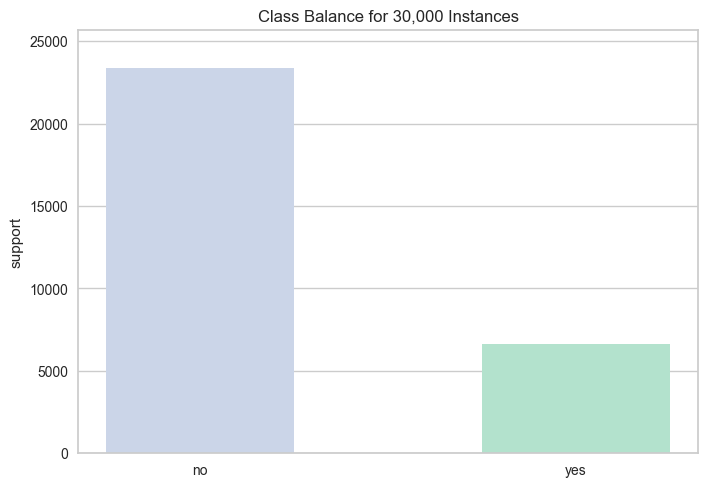

28.40267077555213 %


In [ ]:
# Visualization of class distribution
visualizer = ClassBalance(labels=["no", "yes"], colormap="pastel")

visualizer.fit(df["default.payment.next.month"])

visualizer.show()


# Percentage of 1-yes labels
print(
    (
        (
            (df["default.payment.next.month"] == 1).sum()
            / ((df["default.payment.next.month"] == 0).sum())
        )
    )
    * 100,
    "%",
)

For the dependent variables, there are far more not default payments, which will be additional challenge for ML optimization. This is very unbalanced dataset.

EDUCATION


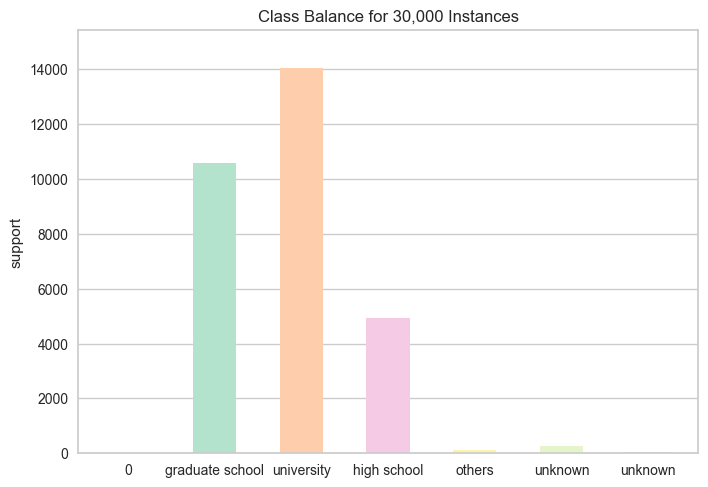

MARRIAGE


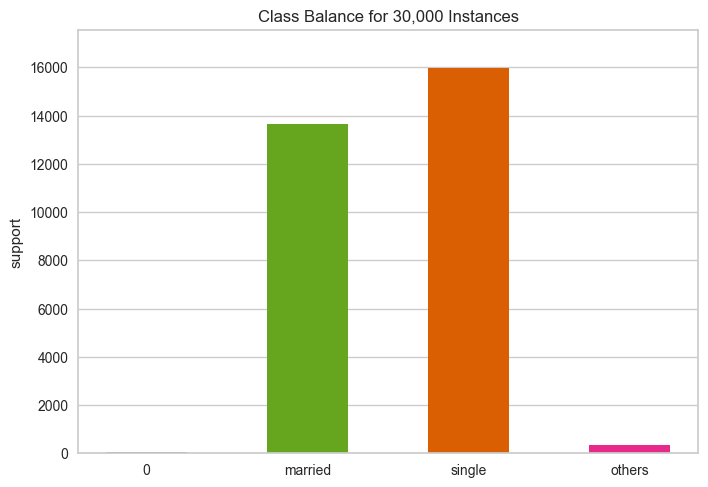

<Axes: title={'center': 'Class Balance for 30,000 Instances'}, ylabel='support'>

In [ ]:
# Visualizing education and marriage
print("EDUCATION")
visualizer = ClassBalance(
    labels=[
        "0",
        "graduate school",
        "university",
        "high school",
        "others",
        "unknown",
        "unknown",
    ],
    colormap="pastel",
)
visualizer.fit(df["EDUCATION"])
visualizer.show()

print("MARRIAGE")
visualizer = ClassBalance(labels=["0", "married", "single", "others"], colormap="dark")
visualizer.fit(df["MARRIAGE"])
visualizer.show()

There are cases of 0 as education/marriage value, which is incorrect with the features description. There are also two unknown groups and one others in marriage. These categorical features needs correction.

In [58]:
# Number of duplicates
df.duplicated().sum()

np.int64(35)

There are 35 suplicates which needs to be deleted.

In [59]:
# Dropping duplicates
df_prep = df.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=True)

In [61]:
def mapping(df):
    """
    Map categorical codes in EDUCATION and MARRIAGE columns to cleaned categories.

    - EDUCATION: 0, 5, 6 mapped to 4 (unknown/others)
    - MARRIAGE: 0 mapped to 3 (others)
    """
    edu_map = {0: 4, 1: 1, 2: 2, 3: 3, 4: 4, 5: 4, 6: 4}
    mar_map = {0: 3, 1: 1, 2: 2, 3: 3}

    df["EDUCATION"] = df["EDUCATION"].map(edu_map)
    df["MARRIAGE"] = df["MARRIAGE"].map(mar_map)
    return df


df_prep = mapping(df)


* Dataset has 30000 samples and 24 features, all numerical
* 35 duplicates
* Columns SEX, MARRIAGE, EDUCATION contains categorical values
* There are no null, but there are some 0 values which aren't provided in data information, they were checked and reassigned
* For the dependent variable, there are far more not default payments, which will be additional challenge for ML optimization

## Gender chart

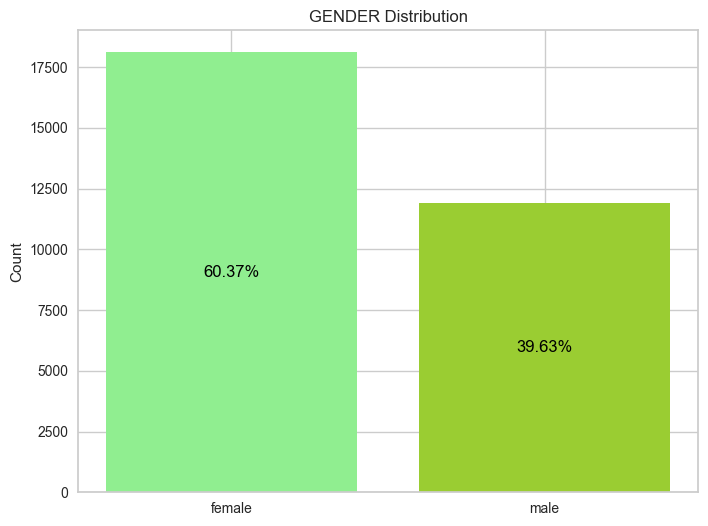

In [65]:
# Gender distribution visualization (1=male, 2=female)

# Calculating percentage of male and female
classes = df_prep["SEX"].value_counts()
labels = ["male", "female"]
values = [classes[2], classes[1]]
total = df_prep["SEX"].count()

male = classes[1] / df_prep["SEX"].count() * 100
female = classes[2] / df_prep["SEX"].count() * 100

# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(["female", "male"], classes, color=["lightgreen", "yellowgreen"])
plt.title("GENDER Distribution")

# Annotate with percentages in the middle of each bar
for i, value in enumerate(values):
    pct = value / total * 100
    plt.annotate(
        f"{pct:.2f}%",
        (i, value / 2),
        ha="center",
        va="center",
        color="black"
    )

plt.ylabel("Count")
plt.show()

Gender isn't balanced, there are more female representatives in dataset.

## Customer default analysis as per Gender

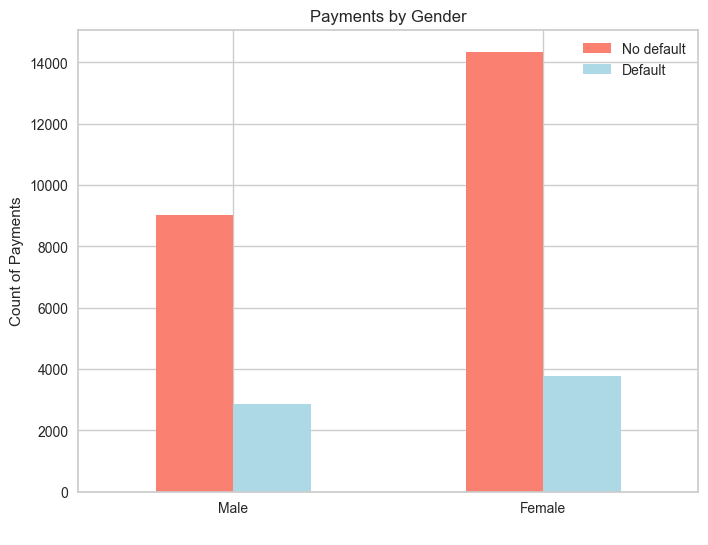

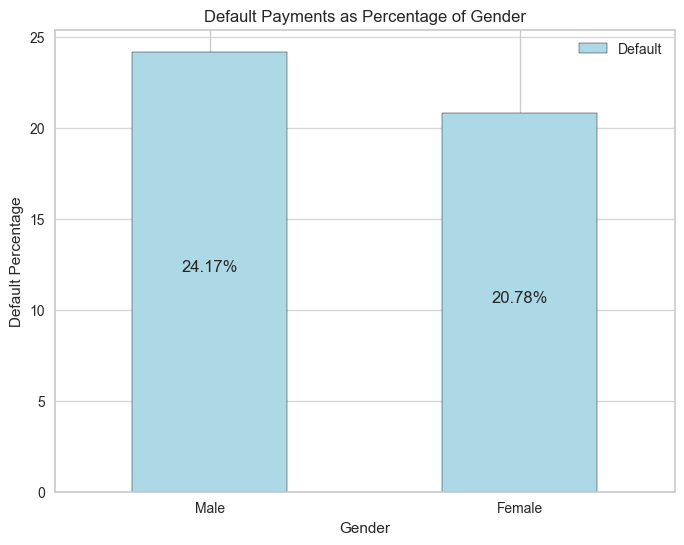

In [60]:
# Simple Customer default analysis as per Gender

# Bar chart: default vs. non-default by gender
pd.crosstab(df_prep["SEX"], df_prep["default.payment.next.month"]).plot(
    kind="bar", figsize=(8, 6), color=["salmon", "lightblue"]
)
plt.title("Payments by Gender")
plt.xlabel(" ")
plt.ylabel("Count of Payments")
plt.legend(["No default", "Default"])
plt.xticks(ticks=[0, 1], labels=["Male", "Female"], rotation=0)
plt.show()

# Calculate default percentage per gender
gender_counts = df_prep.groupby("SEX")["default.payment.next.month"].count()
default_counts = df_prep.groupby("SEX")["default.payment.next.month"].sum()
default_percentages = (default_counts / gender_counts) * 100

# Plot percentage of defaults by gender
plt.figure(figsize=(8, 6))
default_percentages.plot(kind="bar", color=["lightblue"], edgecolor="black")
plt.title("Default Payments as Percentage of Gender")
plt.xlabel("Gender")
plt.ylabel("Default Percentage")

plt.xticks(ticks=[0, 1], labels=["Male", "Female"], rotation=0)
plt.grid(axis="y", alpha=0.75)
plt.legend(["Default"])

for i, pct in enumerate(default_percentages):
    plt.annotate(f"{pct:.2f}%", (i, pct / 2), ha="center")
    
    
plt.show()

Absolute value of female defaulter is more than male defaulter.

Although there is more female defaulters, there are slightly more male defaulters in sex percentage distribution.

## Marital status chart

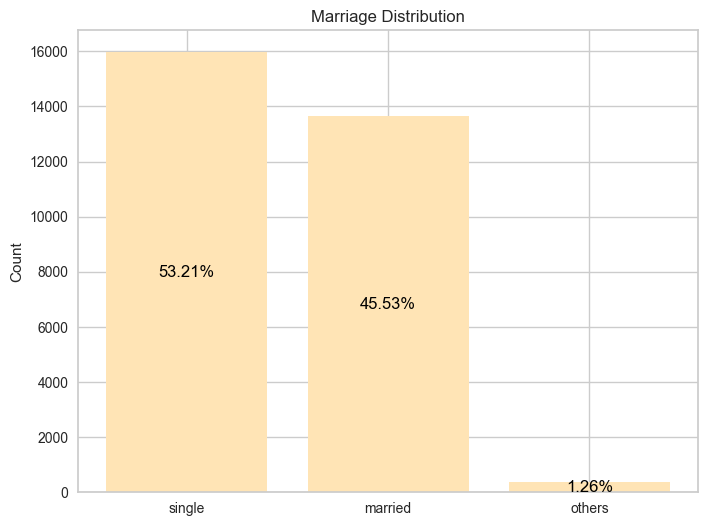

In [66]:
# Visualize marital status distribution and percentage counts

classes = df_prep["MARRIAGE"].value_counts()
labels = ["single", "married", "others"]
values = [classes[2], classes[1], classes[3]]
total = df_prep["MARRIAGE"].count()

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values, color="moccasin")
plt.title("Marriage Distribution")
plt.ylabel("Count")

# Annotate with percentages in the middle of each bar
for i, value in enumerate(values):
    pct = value / total * 100
    plt.annotate(
        f"{pct:.2f}%",
        (i, value / 2),
        ha="center",
        va="center",
        color="black"
    )

plt.show()


## Customer default analysis as per marital status

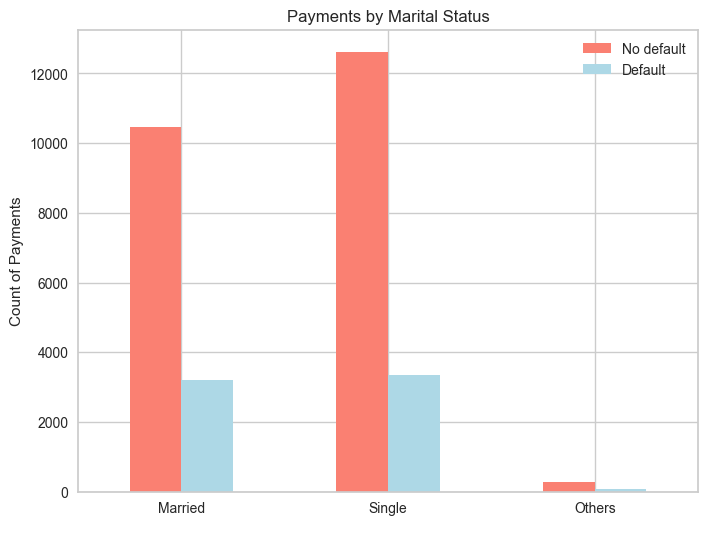

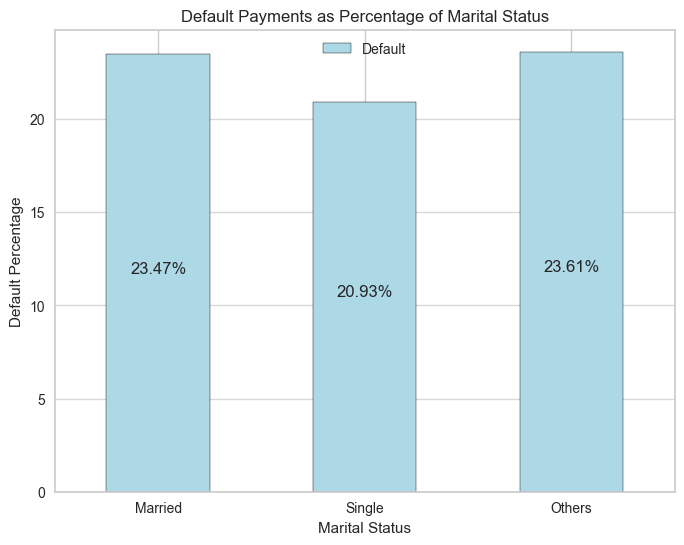

In [ ]:
# Visualize marital status vs. default payment counts and percentages

# Bar chart: count of default payments by marital status
pd.crosstab(df_prep["MARRIAGE"], df_prep["default.payment.next.month"]).plot(kind="bar",figsize=(8,6),color=['salmon','lightblue'])
plt.title('Payments by Marital Status')
plt.xlabel(' ')
plt.ylabel('Count of Payments')
plt.legend(['No default','Default'])
plt.xticks(ticks=[0, 1, 2], labels=['Married', 'Single', "Others"], rotation=0)
plt.show()

# Marital status vs default percentage count
marital_counts = df_prep.groupby('MARRIAGE')['default.payment.next.month'].count()
default_counts = df_prep.groupby('MARRIAGE')['default.payment.next.month'].sum()
default_percentages = (default_counts / marital_counts) * 100

# Default Payments as Percentage of Marital Status
plt.figure(figsize=(8, 6))
default_percentages.plot(kind='bar', color=['lightblue'], edgecolor='black')
plt.title('Default Payments as Percentage of Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Default Percentage')

plt.xticks(ticks=[0, 1, 2], labels=['Married', 'Single', "Others"], rotation=0)
plt.grid(axis='y', alpha=0.75)
plt.legend(['Default'])

for i, pct in enumerate(default_percentages):
    plt.annotate(f"{pct:.2f}%", (i, pct / 2), ha="center")


plt.show()

There isn't a significant correlation between default payments and marital status.

## Education

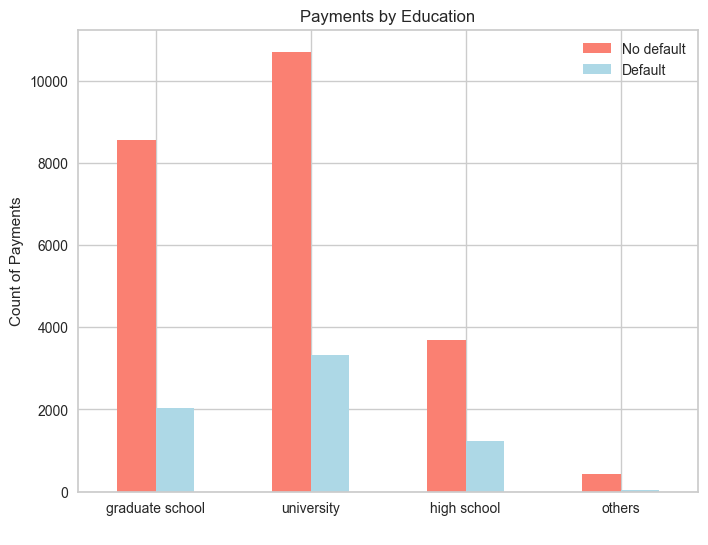

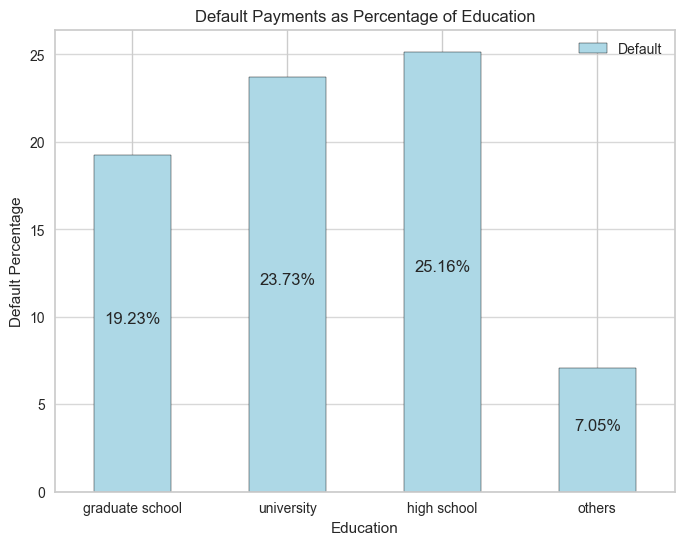

In [ ]:
# Simple visualization of education and default payment
pd.crosstab(df_prep["EDUCATION"], df_prep["default.payment.next.month"]).plot(kind="bar",figsize=(8,6),color=['salmon','lightblue'])
plt.title('Payments by Education')
plt.xlabel(' ')
plt.ylabel('Count of Payments')
plt.legend(['No default','Default'])
plt.xticks(ticks=[0, 1, 2, 3], labels=['graduate school', 'university', "high school", "others"], rotation=0)
plt.show()

# Education vs default percentage count
education_counts = df_prep.groupby('EDUCATION')['default.payment.next.month'].count()
default_counts = df_prep.groupby('EDUCATION')['default.payment.next.month'].sum()
default_percentages = (default_counts / education_counts) * 100

# Default Payments as Percentage of Education
plt.figure(figsize=(8, 6))
default_percentages.plot(kind='bar', color=['lightblue'], edgecolor='black')
plt.title('Default Payments as Percentage of Education')
plt.xlabel('Education')
plt.ylabel('Default Percentage')
plt.xticks(ticks=[0, 1, 2, 3], labels=['graduate school', 'university', "high school", "others"], rotation=0)
plt.grid(axis='y', alpha=0.75)
plt.legend(['Default'])

# Annotate each bar in the middle
for i, pct in enumerate(default_percentages):
    plt.annotate(f"{pct:.2f}%", (i, pct / 2), ha="center")

plt.show()


Absolute numbers of defaulters is maximum among university graduates.

The highest probability of default payment is among high school students.

## Balance Limit correlation

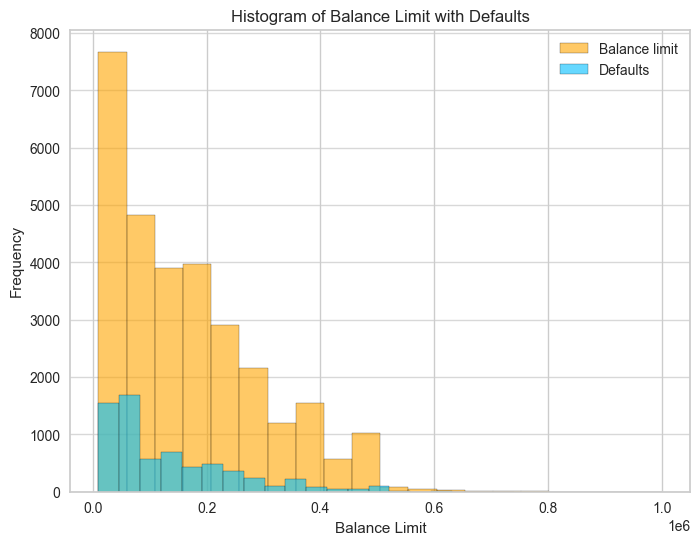

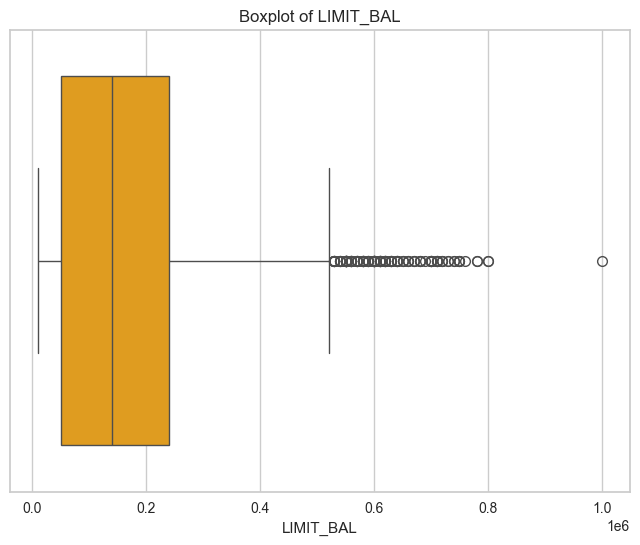

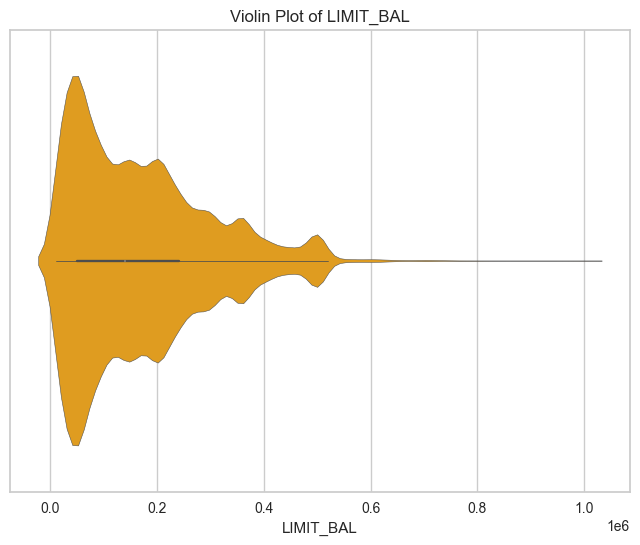

In [72]:
# Histogram to visualize the distribution of 'LIMIT_BAL'

# Histogram for all Balance Limit
plt.figure(figsize=(8, 6))
plt.hist(df['LIMIT_BAL'], bins=20, color='orange', edgecolor='black', alpha=0.6, label='Balance limit')
plt.hist(df[df['default.payment.next.month'] == 1]['LIMIT_BAL'], bins=20, color='deepskyblue', edgecolor='black', alpha=0.6, label='Defaults')
plt.title('Histogram of Balance Limit with Defaults')
plt.xlabel('Balance Limit')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.legend()  # Add legend
plt.show()

# Boxplot of balance limit
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['LIMIT_BAL'], color='orange')
plt.title('Boxplot of LIMIT_BAL')
plt.xlabel('LIMIT_BAL')
plt.show()

# Violin plot of balance limit distribution
plt.figure(figsize=(8, 6))
sns.violinplot(x=df['LIMIT_BAL'], color='orange')
plt.title('Violin Plot of LIMIT_BAL')
plt.xlabel('LIMIT_BAL')
plt.show()

Histogram is right skewed. Visible cluster of more common credit limits on the lower side. From Boxplot we see IQR (50% of all data) ~50-250k. Peaks in the violin plot indicate that values are concentrated ~50k.

Frequency of default payments decreases with lincreasing balance limit.

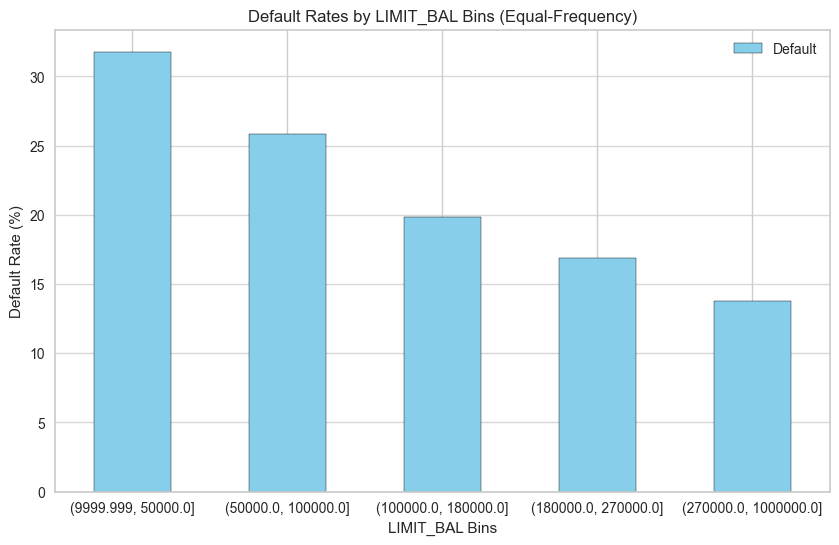


Number of entries in each LIMIT_BAL bin:
LIMIT_BAL_bins
(9999.999, 50000.0]      7676
(100000.0, 180000.0]     6123
(270000.0, 1000000.0]    5958
(180000.0, 270000.0]     5421
(50000.0, 100000.0]      4822
Name: count, dtype: int64


In [62]:
# Create equal-frequency bins for LIMIT_BAL and analyze default rate

df_prep['LIMIT_BAL_bins'] = pd.qcut(df_prep['LIMIT_BAL'], q=5)

# Calculate default rates for each bin
default_rates = df_prep.groupby('LIMIT_BAL_bins', observed=True)['default.payment.next.month'].mean() * 100  # Convert to percentage

# Count total entries in each bin (optional for understanding bin sizes)
bin_counts = df_prep['LIMIT_BAL_bins'].value_counts()

# Plot default rates by LIMIT_BAL bins
plt.figure(figsize=(10, 6))
default_rates.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Default Rates by LIMIT_BAL Bins (Equal-Frequency)')
plt.xlabel('LIMIT_BAL Bins')
plt.ylabel('Default Rate (%)')
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=0)
plt.legend(['Default'])
plt.show()

# Print bin counts for review
print("\nNumber of entries in each LIMIT_BAL bin:")
print(bin_counts)

# Converting bins to categorical ((OHE)/SMOTE can work on interval features created after binning, but it requires some preprocessing).
df_prep['LIMIT_BAL_bins'] = df_prep['LIMIT_BAL_bins'].astype('category').cat.codes # If converted to string earlier then category, then int8

The default rate is highest in Bin 1 (the lowest credit limit group) and gradually decreases as credit limits increase. This suggests a negative correlation between credit limit (LIMIT_BAL) and default **likelihood**.




## Age

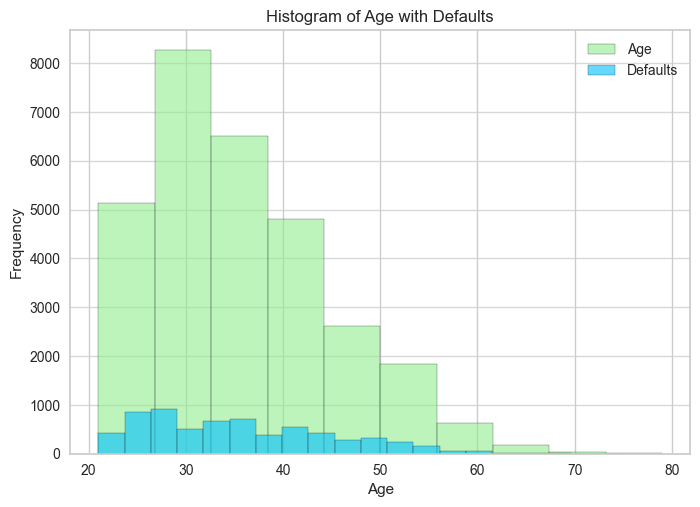

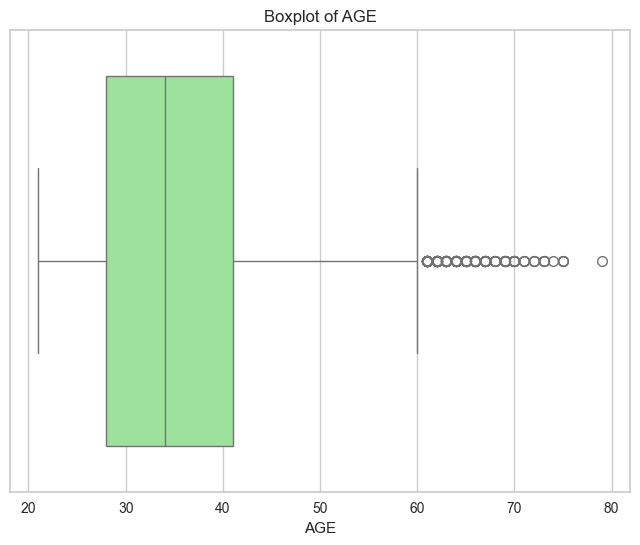

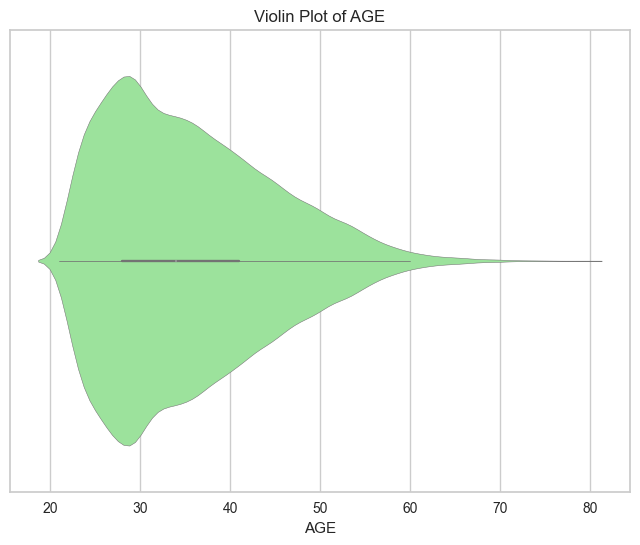

In [73]:
# Histogram to visualize the distribution of 'AGE'

# Plot histogram for all AGE
plt.hist(df['AGE'], bins=10, color='lightgreen', edgecolor='black', alpha=0.6, label='Age')

# Plot histogram for defaults only
plt.hist(df[df['default.payment.next.month'] == 1]['AGE'], bins=20, color='deepskyblue', edgecolor='black', alpha=0.6, label='Defaults')

# Add titles and labels
plt.title('Histogram of Age with Defaults')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.legend()  # Add legend
plt.show()

# Boxplot to detect outliers and see spread
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['AGE'], color='lightgreen')
plt.title('Boxplot of AGE')
plt.xlabel('AGE')
plt.show()

# Violin plot for detailed distribution and density
plt.figure(figsize=(8, 6))
sns.violinplot(x=df['AGE'], color='lightgreen')
plt.title('Violin Plot of AGE')
plt.xlabel('AGE')
plt.show()

The most clients are between 25-30 years. Maximum number of defaulting customers are between 25-30. Visible cluster of more common age  on the lower side. From Boxplot we see IQR (50% of all data) ~27-41 years.

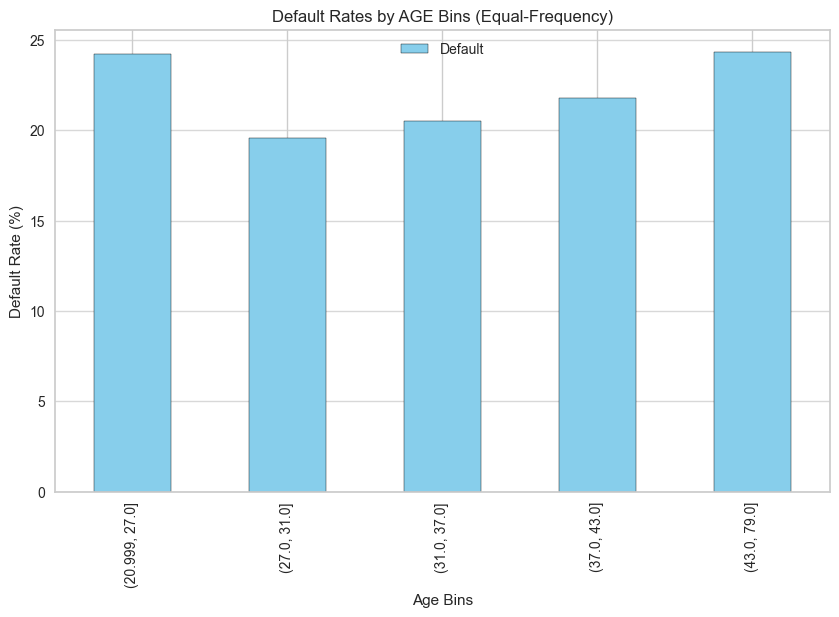


Number of entries in each LIMIT_BAL bin:
AGE_bins
(31.0, 37.0]      6728
(20.999, 27.0]    6604
(43.0, 79.0]      5986
(27.0, 31.0]      5626
(37.0, 43.0]      5056
Name: count, dtype: int64


In [63]:
# Create equal-frequency bins for LIMIT_BAL for ML
df_prep['AGE_bins'] = pd.qcut(df_prep['AGE'], q=5)

# Calculate default rates for each bin
default_rates = df_prep.groupby('AGE_bins', observed=True)['default.payment.next.month'].mean() * 100  # Convert to percentage

# Count total entries in each bin (optional for understanding bin sizes)
bin_counts = df_prep['AGE_bins'].value_counts()

# Plot default rates by LIMIT_BAL bins
plt.figure(figsize=(10, 6))
default_rates.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Default Rates by AGE Bins (Equal-Frequency)')
plt.xlabel('Age Bins')
plt.ylabel('Default Rate (%)')
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=90)
plt.legend(['Default'])
plt.show()

# Print bin counts for review
print("\nNumber of entries in each LIMIT_BAL bin:")
print(bin_counts)

# Converting bins to categorical ((OHE)/SMOTE can work on interval features created after binning, but it requires some preprocessing).
df_prep['AGE_bins'] = df_prep['AGE_bins'].astype('category').cat.codes # If converted to string earlier then category, then int8

Default payment likelihood is the highest for 21-25. After age 40 likelihood have a constant possitive correlation.

## Outliers

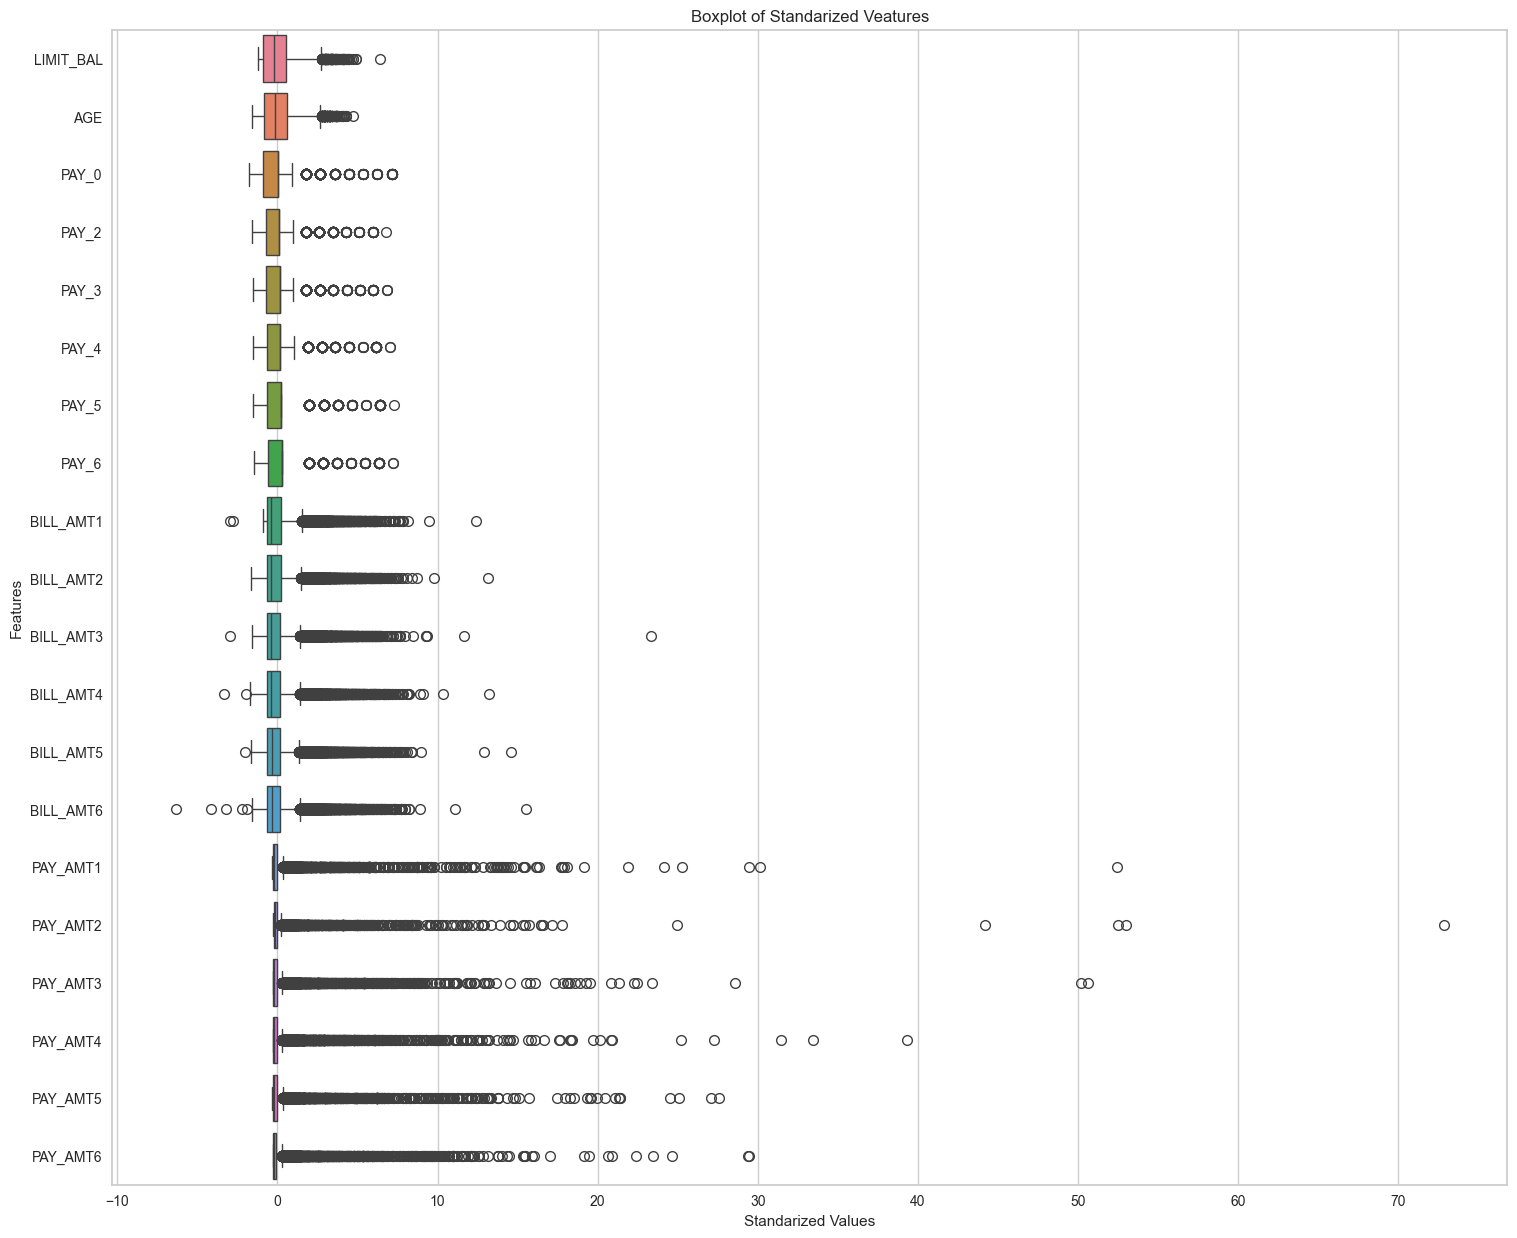

In [22]:
# Outliers visualization
sc = StandardScaler()
labels = df_prep.drop(columns=["default.payment.next.month", "LIMIT_BAL_bins", "AGE_bins", "SEX", "EDUCATION", "MARRIAGE"]).columns
df_sc = sc.fit_transform(df[labels])
plt.figure(figsize=(18, 15))
sns.boxplot(data=df_sc, orient="h")
plt.yticks(ticks=range(len(labels)), labels=labels)
plt.xlabel("Standarized Values")
plt.ylabel("Features")
plt.title("Boxplot of Standarized Veatures")
plt.show()

* PAY_AMT1 - PAY_AMT6  a few clients made very large repayments compared to the rest.
* BILL_AMT skewed distribution where some customers have significantly higher bills
* LIMIT_BAL indicating a few customers with exceptionally high credit limits.
* AGE skewed distribution where some customers are significantly older 
* PAY_0 to PAY_6 variables show clear separation in values, as expected from their ordinal encoding

## Heatmap

<Axes: >

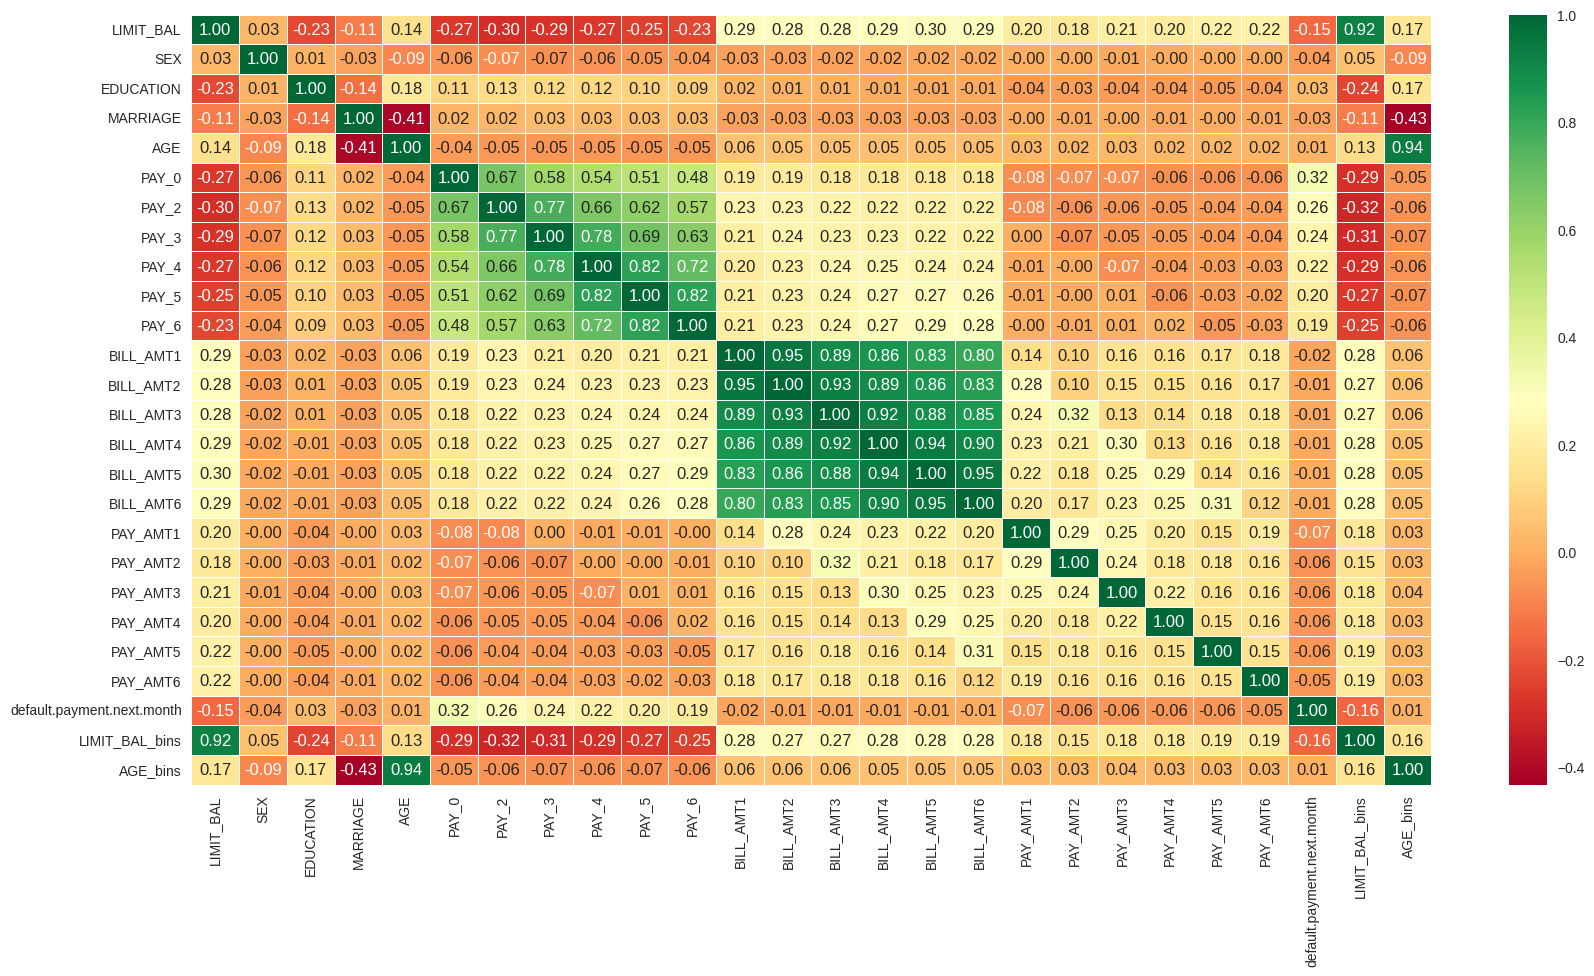

In [ ]:
# First Correlation Heatmap visualization code (mapped data & created binns for age and limit_bal)
corrmat = df_prep.corr(numeric_only=True)
plt.figure(figsize=(20,10))
sns.heatmap(df_prep[corrmat.index].corr(),annot=True,linewidths=0.5,fmt='.2f',cmap="RdYlGn")

 Key Variables Related to Default Payment (default.payment.next.month)


**Top correlated variables:**

PAY_x:
* These represent the repayment status in previous months.
* Positive correlation: Higher delinquency levels in repayment history increase the likelihood of default.
* The highest correlation has the most recent month

LIMIT_BAL (correlation ≈ -0.15):
* Negative correlation suggests customers with higher credit limits are less likely to default, accurate with earlier findings.



**Strong Relationships Among Predictors:**

PAY_x, BILL_ATM_x:

* These represent statuses across months and are strongly correlated since they track similar behaviors over time.
* This means they carry redundant information, leading to multicollinearity.
* Multicollinearity can negatively impact models like logistic regression by inflating coefficients and reducing interpretability.
* Summarization or dimensionality reduction (e.g., PCA) might help.

## PCAS & t-SNE

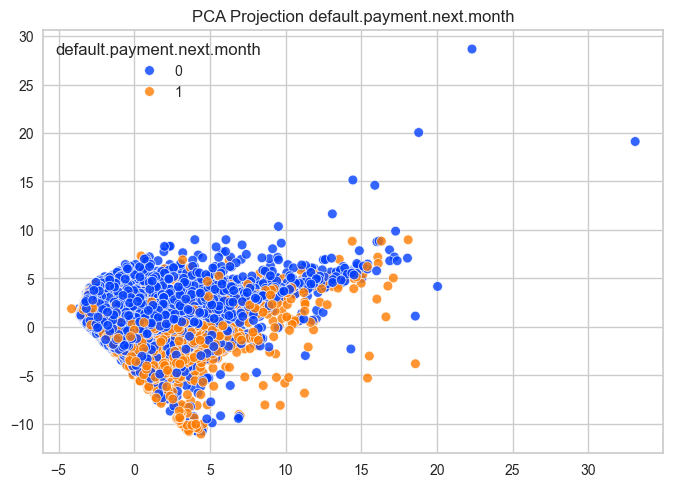

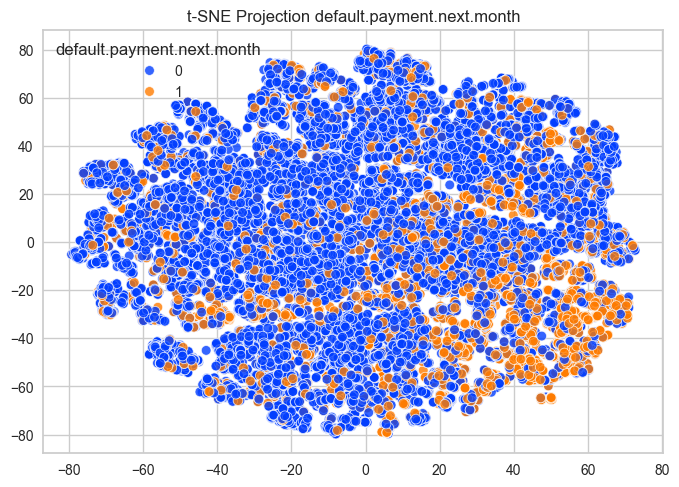

In [42]:
def visualize_dimensionality_reduction(df, target_col):
    """Visualize separability using PCA and t-SNE."""
    features = df.drop(columns=target_col)
    y = df[target_col]
    X_scaled = StandardScaler().fit_transform(features.select_dtypes(include=np.number))

    # PCA projection
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    sns.scatterplot(
        x=X_pca[:, 0],
        y=X_pca[:, 1],
        hue=y,
        palette="bright",
        alpha=0.8,
        edgecolor="white",
    )
    plt.title(f"PCA Projection {y.name}")
    plt.show()

    # t-SNE projection
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
    X_tsne = tsne.fit_transform(X_scaled)
    sns.scatterplot(
        x=X_tsne[:, 0],
        y=X_tsne[:, 1],
        hue=y,
        palette="bright",
        alpha=0.8,
        edgecolor="white",
    )
    plt.title(f"t-SNE Projection {y.name}")
    plt.show()


visualize_dimensionality_reduction(df_prep, "default.payment.next.month")

* PCA shows that linear separation is weak—not surprising in imbalanced or noisy real-world data.
* t-SNE provides better visual separability, revealing possible clusters worth exploring further (e.g., via clustering, SMOTE, or targeted feature engineering).
* These insights justify using nonlinear models like CatBoost or XGBoost, and possibly dimensionality reduction as preprocessing in exploratory pipelines.

# Data split

In [21]:
def stratify_splitting(df, target_col):
    """
    Perform stratified splitting based on HealthImpactClass.

    Returns:
        strat_train_set (DataFrame): Training set.
        strat_test_set (DataFrame): Test set.
        feature_names (Index): List of feature column names.
    """
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    try:
        for train_index, test_index in split.split(df, df[target_col]):
            strat_train_set = df.iloc[train_index]
            strat_test_set = df.iloc[test_index]
        feature_names = strat_train_set.drop(
            columns=target_col
        ).columns
        return strat_train_set, strat_test_set, feature_names
    except Exception as e:
        print(f"Error while splitting: {e}")
        return None


def xy_splitting_scaling(strat_train_set, strat_test_set, target_col, feature_names):
    """
    Split features and targets, apply standard scaling.

    Returns:
        X_train, y_train, X_test, y_test (arrays): Scaled NumPy arrays.
    """
    try:
        X_train = strat_train_set.drop(
            columns=target_col
        )
        y_train = strat_train_set[target_col]
        X_test = strat_test_set.drop(columns=target_col)
        y_test = strat_test_set[target_col]

        scaler = StandardScaler()
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=feature_names)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=feature_names)

        return X_train, y_train, X_test, y_test
    except Exception as e:
        print(f"Error while xy_splitting: {e}")
        return None

In [ ]:

strat_train_set, strat_test_set, feature_names = stratify_splitting(df_prep, "default.payment.next.month")
X_train, y_train, X_test, y_test = xy_splitting_scaling(
    strat_train_set, strat_test_set, "default.payment.next.month", feature_names
)

# ML

## Model Benchmarking

In [ ]:
# Define models
models = {
    "log": LogisticRegression(solver="lbfgs"),  # margin-based
    "svc": SVC(probability=True, random_state=SEED),  # margin-based
    "rf": RandomForestClassifier(random_state=SEED),  # Bagging
    "lgbm": LGBMClassifier(verbose=-1),  # Boosting
    "xgb": XGBClassifier(),
    "cat": CatBoostClassifier(verbose=0),  # Boosting
}

In [51]:
def evaluate_model(models, X_train, y_train, X_test, y_test):
    """
    Evaluate classification models on test data.

    Trains models, calculates evaluation metrics (precision, recall, F1, accuracy, ROC-AUC),
    and plots confusion matrices.

    Args:
        models (dict): Dictionary of model names and instantiated models.
        X_train (array): Training feature set.
        y_train (array): Training labels.
        X_test (array): Test feature set.
        y_test (array): Test labels.
    """
    
    # Define evaluation metrics
    metrics = [precision_score, recall_score, f1_score]
    
    # Initialize storage for metrics
    scores_train = []
    scores_test = []
    
    plt.figure(figsize=(10, 6))

    # Compute precision, recall, f1-score
    for i, (name, model) in enumerate(models.items()):
        model.fit(X_train, y_train)
        preds_train = model.predict(X_train)
        preds_test = model.predict(X_test)
        preds_proba_train = None

        # Check if predict_proba is available
        if hasattr(model, "predict_proba"):
            preds_proba_train = model.predict_proba(X_train)
            preds_proba_test = model.predict_proba(X_test)

        # Initialize dictionaries for storing model scores
        model_scores_train = {"Model": name}
        model_scores_test = {"Model": name}
        for metric in metrics:
            model_scores_train[metric.__name__] = metric(
                y_train,
                preds_train,
                average="weighted",
                zero_division=0,
            )
            model_scores_test[metric.__name__] = metric(
                y_test,
                preds_test,
                average="weighted",
                zero_division=0,
            )

        model_scores_train["accuracy"] = accuracy_score(
            y_train, preds_train,
        )
        model_scores_test["accuracy"] = accuracy_score(
            y_test, preds_test,
        )

        # Compute ROC AUC for multi-class
        if preds_proba_train is not None:
            model_scores_train["roc_auc"] = roc_auc_score(
                y_train,
                preds_proba_train[:, 1],
            )
            model_scores_test["roc_auc"] = roc_auc_score(
                y_test,
                preds_proba_test[:, 1],
            )

        # Store results
        scores_train.append(model_scores_train)
        scores_test.append(model_scores_test)

        # Plot confusion matrix
        conf_matrix = confusion_matrix(y_test, preds_test)
        plt.subplot(2, 3, i + 1)
        sns.heatmap(
            conf_matrix,
            annot=True,
            fmt=".0f",
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test),
        )
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(f"Confusion Matrix: {name}")

    plt.tight_layout()
    plt.show()

    # Convert results to DataFrame and display
    results_df_train = pd.DataFrame(scores_train)
    results_df_test = pd.DataFrame(scores_test)

    # Print scores in tabular format
    print("\n=== Train Metrics ===")
    print(results_df_train.to_string(index=False, float_format="%.4f"))

    print("\n=== Test Metrics ===")
    print(results_df_test.to_string(index=False, float_format="%.4f"))

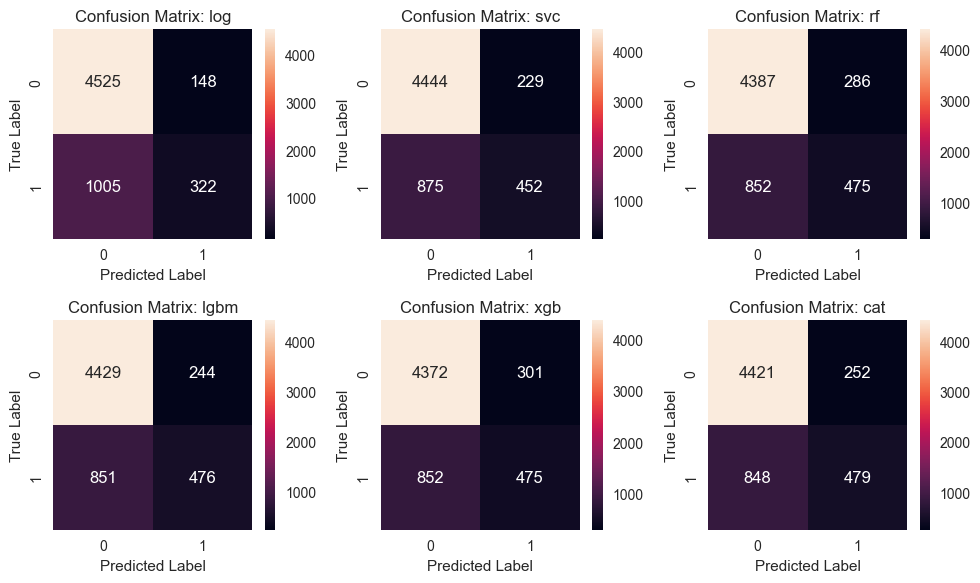


=== Train Metrics ===
Model  precision_score  recall_score  f1_score  accuracy  roc_auc
  log           0.7965        0.8118    0.7743    0.8118   0.7282
  svc           0.8104        0.8250    0.8023    0.8250   0.7935
   rf           0.9995        0.9995    0.9995    0.9995   1.0000
 lgbm           0.8329        0.8425    0.8251    0.8425   0.8847
  xgb           0.8874        0.8881    0.8788    0.8881   0.9449
  cat           0.8513        0.8570    0.8421    0.8570   0.8886

=== Test Metrics ===
Model  precision_score  recall_score  f1_score  accuracy  roc_auc
  log           0.7888        0.8078    0.7701    0.8078   0.7080
  svc           0.7975        0.8160    0.7924    0.8160   0.7167
   rf           0.7902        0.8103    0.7900    0.8103   0.7538
 lgbm           0.7995        0.8175    0.7960    0.8175   0.7738
  xgb           0.7872        0.8078    0.7880    0.8078   0.7601
  cat           0.7984        0.8167    0.7956    0.8167   0.7768


In [ ]:
# Initial dataset analysis
X_train = pd.read_csv("../data/processed/X_train_scaled.csv").values
X_test = pd.read_csv("../data/processed/X_test_scaled.csv").values
y_train = pd.read_csv("../data/processed/y_train_scaled.csv").values.flatten()
y_test = pd.read_csv("../data/processed/y_test_scaled.csv").values.flatten()

evaluate_model(models, X_train, y_train, X_test, y_test)


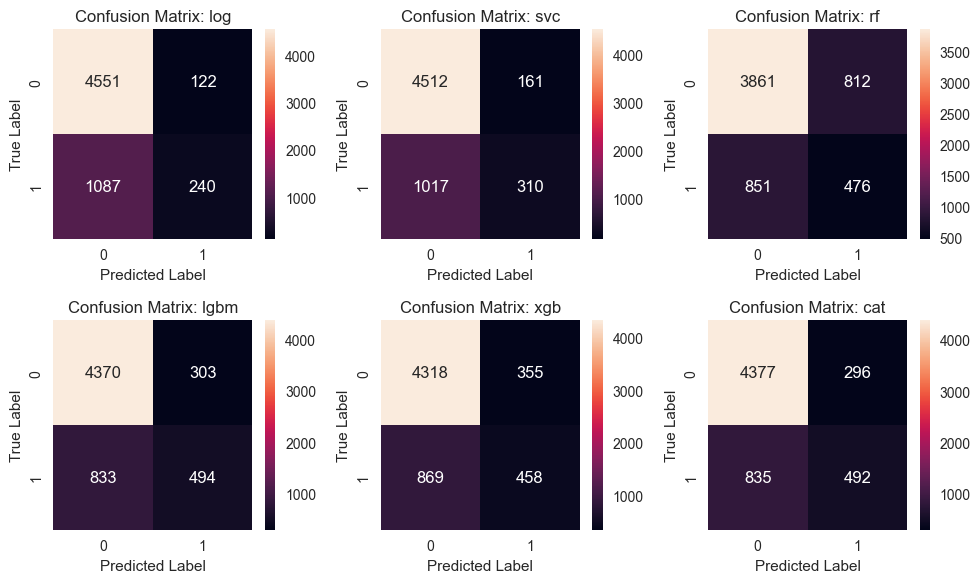


=== Train Metrics ===
Model  precision_score  recall_score  f1_score  accuracy  roc_auc
  log           0.7477        0.7638    0.7295    0.7638   0.7302
  svc           0.7796        0.7887    0.7648    0.7887   0.8200
   rf           0.9989        0.9989    0.9989    0.9989   1.0000
 lgbm           0.8373        0.8364    0.8219    0.8364   0.9041
  xgb           0.9072        0.9031    0.8979    0.9031   0.9703
  cat           0.8395        0.8393    0.8260    0.8393   0.9018

=== Test Metrics ===
Model  precision_score  recall_score  f1_score  accuracy  roc_auc
  log           0.7753        0.7985    0.7504    0.7985   0.6995
  svc           0.7811        0.8037    0.7652    0.8037   0.6253
   rf           0.7199        0.7228    0.7213    0.7228   0.6495
 lgbm           0.7912        0.8107    0.7921    0.8107   0.7627
  xgb           0.7729        0.7960    0.7768    0.7960   0.7342
  cat           0.7921        0.8115    0.7926    0.8115   0.7611


In [ ]:
# Without outliers on train set dataset analysis
strat_train_set = pd.read_csv("../data/processed/strat_train_set.csv")
strat_test_set = pd.read_csv("../data/processed/strat_test_set.csv")
feature_names = strat_train_set.drop(columns=["default.payment.next.month"]).columns
columns = strat_train_set.drop(
    columns=[
        "SEX",
        "EDUCATION",
        "MARRIAGE",
        "PAY_0",
        "PAY_2",
        "PAY_3",
        "PAY_4",
        "PAY_5",
        "PAY_6",
        "default.payment.next.month",
        "LIMIT_BAL_bins",
        "AGE_bins",
    ]
).columns


def remove_outliers_iqr(strat_train_set, columns):
    """Remove outliers using IQR method."""
    for column in columns:
        Q1 = strat_train_set[column].quantile(0.25)
        Q3 = strat_train_set[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filter out outliers
        strat_train_set = strat_train_set[
            (strat_train_set[column] >= lower_bound)
            & (strat_train_set[column] <= upper_bound)
        ]

    return strat_train_set


strat_train_set = remove_outliers_iqr(strat_train_set, columns)
X_train, y_train, X_test, y_test = xy_splitting_scaling(
    strat_train_set, strat_test_set, "default.payment.next.month", feature_names
)

# Standard data after preprodessing
evaluate_model(models, X_train, y_train, X_test, y_test)

In [ ]:
def log_transform_skewed_features_safe(train_df, test_df, skew_threshold=1.0):
    """
    Apply log1p to skewed columns, safely ignoring or clipping invalid values.
    """
    numeric_cols = train_df.select_dtypes(include=np.number).drop(
        columns=["default.payment.next.month"], errors="ignore"
    )
    skewness = train_df[numeric_cols.columns].skew()
    skewed_cols = skewness[abs(skewness) > skew_threshold].index.tolist()

    print("Log-transforming these skewed columns:", skewed_cols)

    train_df = train_df.copy()
    test_df = test_df.copy()

    for col in skewed_cols:
        if (train_df[col] <= -1).any() or (test_df[col] <= -1).any():
            print(f"Skipping '{col}' due to values <= -1 that break log1p.")
            continue
        train_df[col] = np.log1p(train_df[col].clip(lower=0))
        test_df[col] = np.log1p(test_df[col].clip(lower=0))

    return train_df, test_df


strat_train_set = pd.read_csv("../data/processed/strat_train_set.csv")
strat_test_set = pd.read_csv("../data/processed/strat_test_set.csv")
feature_names = strat_train_set.drop(columns=["default.payment.next.month"]).columns


strat_train_set_log, strat_test_set_log = log_transform_skewed_features_safe(
    strat_train_set, strat_test_set
)

Log-transforming these skewed columns: ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
Skipping 'BILL_AMT1' due to values <= -1 that break log1p.
Skipping 'BILL_AMT2' due to values <= -1 that break log1p.
Skipping 'BILL_AMT3' due to values <= -1 that break log1p.
Skipping 'BILL_AMT4' due to values <= -1 that break log1p.
Skipping 'BILL_AMT5' due to values <= -1 that break log1p.
Skipping 'BILL_AMT6' due to values <= -1 that break log1p.


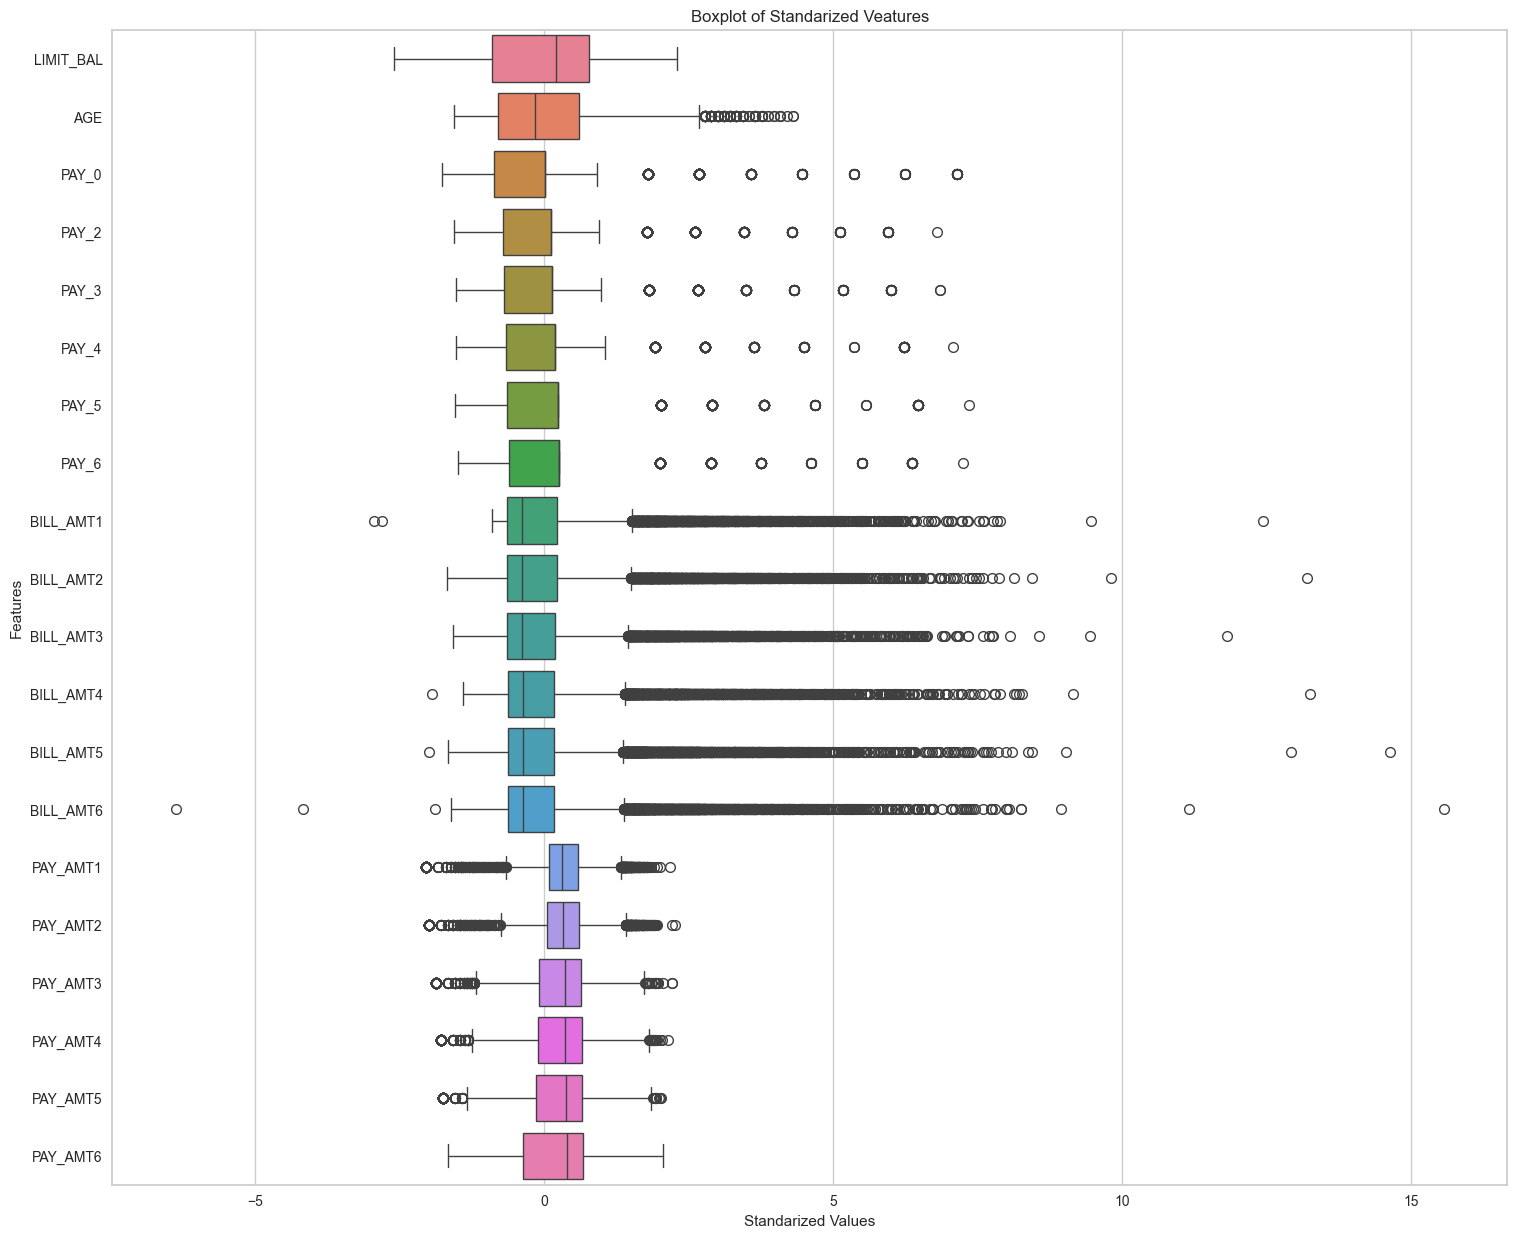

In [ ]:
# Outliers visualization after log-transforation
sc = StandardScaler()
labels = strat_train_set_log.drop(columns=["default.payment.next.month", "LIMIT_BAL_bins", "AGE_bins", "SEX", "EDUCATION", "MARRIAGE"]).columns
df_sc = sc.fit_transform(strat_train_set_log[labels])
plt.figure(figsize=(18, 15))
sns.boxplot(data=df_sc, orient="h")
plt.yticks(ticks=range(len(labels)), labels=labels)
plt.xlabel("Standarized Values")
plt.ylabel("Features")
plt.title("Boxplot of Standarized Veatures")
plt.show()

The new standardized distributions are cleaner and more model-friendly, especially for linear models or neural networks.

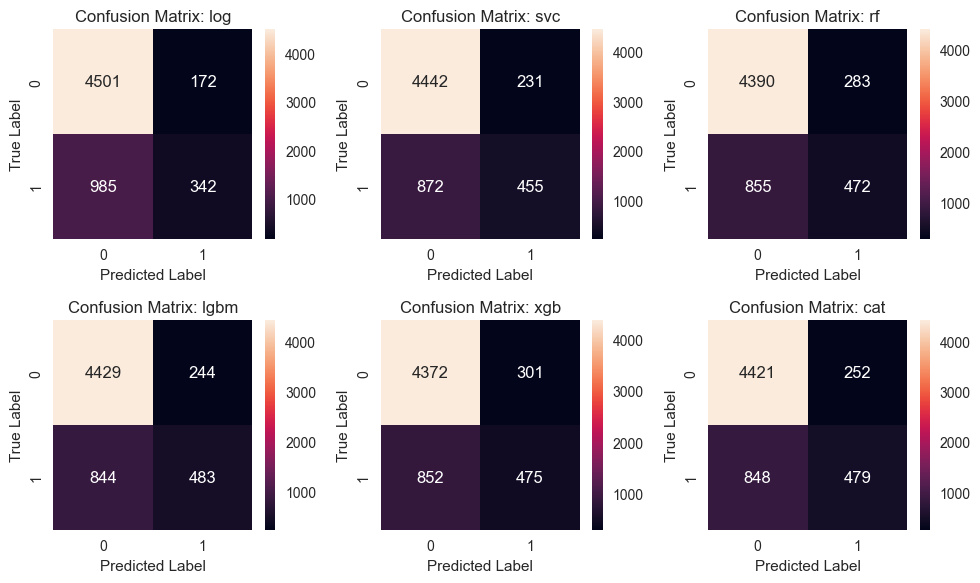


=== Train Metrics ===
Model  precision_score  recall_score  f1_score  accuracy  roc_auc
  log           0.7894        0.8087    0.7727    0.8087   0.7498
  svc           0.8159        0.8291    0.8073    0.8291   0.8139
   rf           0.9995        0.9995    0.9995    0.9995   1.0000
 lgbm           0.8345        0.8437    0.8265    0.8437   0.8854
  xgb           0.8874        0.8881    0.8788    0.8881   0.9449
  cat           0.8513        0.8570    0.8421    0.8570   0.8886

=== Test Metrics ===
Model  precision_score  recall_score  f1_score  accuracy  roc_auc
  log           0.7862        0.8072    0.7723    0.8072   0.7345
  svc           0.7977        0.8162    0.7928    0.8162   0.7122
   rf           0.7901        0.8103    0.7897    0.8103   0.7535
 lgbm           0.8011        0.8187    0.7977    0.8187   0.7738
  xgb           0.7872        0.8078    0.7880    0.8078   0.7601
  cat           0.7984        0.8167    0.7956    0.8167   0.7768


In [ ]:
X_train_log, y_train, X_test_log, y_test = xy_splitting_scaling(
    strat_train_set_log, strat_test_set_log, "default.payment.next.month", feature_names
)

# Dataset with logarithmic transformation
evaluate_model(models, X_train_log, y_train, X_test_log, y_test)

In [ ]:
X_train = pd.read_csv("../data/processed/X_train_scaled.csv").values
X_test = pd.read_csv("../data/processed/X_test_scaled.csv").values
y_train = pd.read_csv("../data/processed/y_train_scaled.csv").values.flatten()
y_test = pd.read_csv("../data/processed/y_test_scaled.csv").values.flatten()

# Print class distributions
print("Before SMOTE + Tomek Links (Training):")
print(np.asarray(np.unique(y_train, return_counts=True)).T)

# Apply SMOTETomek
smote_tomek = SMOTETomek(random_state=SEED)
X_train_smote, y_train_smote = smote_tomek.fit_resample(X_train, y_train)

# Print class distributions after SMOTE
print("\nAfter SMOTE + Tomek Links (Training):")
print(np.asarray(np.unique(y_train_smote, return_counts=True)).T)
# DO NOT apply SMOTETomek to the test set
print("\nTest set class distribution (untouched):")
print(np.asarray(np.unique(y_test, return_counts=True)).T) 

Before SMOTE + Tomek Links (Training):
[[    0 18691]
 [    1  5309]]

After SMOTE + Tomek Links (Training):
[[    0 18314]
 [    1 18314]]

Test set class distribution (untouched):
[[   0 4673]
 [   1 1327]]


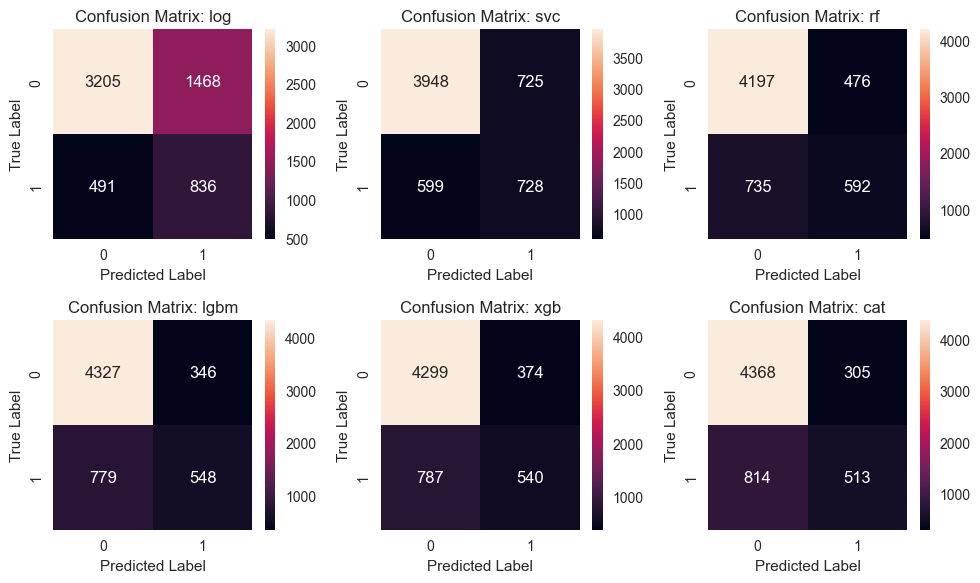


=== Train Metrics ===
Model  precision_score  recall_score  f1_score  accuracy  roc_auc
  log           0.6834        0.6832    0.6831    0.6832   0.7397
  svc           0.7465        0.7328    0.7290    0.7328   0.8226
   rf           0.9996        0.9996    0.9996    0.9996   1.0000
 lgbm           0.8924        0.8877    0.8873    0.8877   0.9535
  xgb           0.9214        0.9180    0.9179    0.9180   0.9778
  cat           0.9112        0.9067    0.9064    0.9067   0.9686

=== Test Metrics ===
Model  precision_score  recall_score  f1_score  accuracy  roc_auc
  log           0.7556        0.6735    0.6984    0.6735   0.7108
  svc           0.7870        0.7793    0.7828    0.7793   0.7501
   rf           0.7854        0.7982    0.7900    0.7982   0.7533
 lgbm           0.7956        0.8125    0.7984    0.8125   0.7693
  xgb           0.7890        0.8065    0.7928    0.8065   0.7532
  cat           0.7952        0.8135    0.7962    0.8135   0.7673


In [96]:
evaluate_model(models, X_train_smote, y_train_smote, X_test, y_test)

In the benchmarking stage, multiple classification models were evaluated across various preprocessing strategies: baseline, outlier removal, log transformation, and SMOTETomek resampling. While performance differences across datasets were relatively subtle, models trained on the log-transformed and SMOTE-balanced data showed slightly better generalization. Among all models, CatBoost and LightGBM consistently delivered strong test performance across accuracy, F1-score, and ROC-AUC, making them strong candidates for further tuning and interpretation.

## Hyperparameters tuning

In [5]:
def evaluate_tuned(best_model, X_train, y_train, X_test, y_test, model_name):
    """
    Evaluate the performance of a classification model.

    This function computes standard classification metrics on both
    training and test sets, displays a confusion matrix heatmap, and
    prints a classification report.

    Args:
        best_model: Trained classification model with predict and predict_proba methods.
        X_train (np.ndarray): Training feature matrix.
        y_train (np.ndarray): Training labels.
        X_test (np.ndarray): Test feature matrix.
        y_test (np.ndarray): Test labels.
        model_name (str): Identifier for the model.

    Returns:
        None
    """
    
    # Define evaluation metrics
    metrics = [precision_score, recall_score, f1_score]
    
    # Initialize storage for metrics
    scores_train = []
    scores_test = []
        
    # Make predictions
    preds_train = best_model.predict(X_train)
    preds_test = best_model.predict(X_test)
    preds_proba_train = best_model.predict_proba(X_train)
    preds_proba_test = best_model.predict_proba(X_test)

    # Initialize dictionaries for storing model scores
    model_scores_train = {"Model": model_name}
    model_scores_test = {"Model": model_name}

    # Compute precision, recall, f1-score
    for metric in metrics:
        model_scores_train[metric.__name__] = metric(
            y_train,
            preds_train,
            average="weighted",
            zero_division=0,
        )
        model_scores_test[metric.__name__] = metric(
            y_test,
            preds_test,
            average="weighted",
            zero_division=0,
        )

    model_scores_train["accuracy"] = accuracy_score(
        y_train, preds_train
    )
    model_scores_test["accuracy"] = accuracy_score(
        y_test, preds_test
    )

    # Compute ROC AUC for multi-class
    model_scores_train["roc_auc"] = roc_auc_score(
        y_train,
        preds_proba_train[:, 1],
    )
    model_scores_test["roc_auc"] = roc_auc_score(
        y_test,
        preds_proba_test[:, 1],
    )

    # Store results
    scores_train.append(model_scores_train)
    scores_test.append(model_scores_test)

    # Print classification report
    print("\n=== Classification Report ===")
    print(classification_report(y_test, preds_test))


    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_test, preds_test)


    # Plot confusion matrix
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt=".0f",
        xticklabels=np.unique(y_test),
        yticklabels=np.unique(y_test),
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


    # Convert results to DataFrame and display
    results_df_train = pd.DataFrame(scores_train)
    results_df_test = pd.DataFrame(scores_test)
    
    # Print scores in tabular format
    print("\n=== Train Metrics ===")
    print(results_df_train.to_string(index=False, float_format="%.4f"))

    print("\n=== Test Metrics ===")
    print(results_df_test.to_string(index=False, float_format="%.4f"))

In [4]:
# Model training using randomized grid search for training speed-up
def model_tuning(model, param_grid, n_iter, X_train, y_train):
    """
    Perform hyperparameter tuning using RandomizedSearchCV.

    Args:
        model: Estimator to be tuned.
        param_grid (dict): Dictionary of parameter distributions.
        n_iter (int): Number of parameter settings sampled.

    Returns:
        best_model: Estimator with the best found parameters.
    """
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

    # RandomizedSearchCV
    GS = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=n_iter,
        scoring="f1_weighted",
        cv=folds,
        return_train_score=True,
        verbose=1,
        n_jobs=-1,  # Use all CPUs
        refit=True,
        random_state=SEED,
        error_score=0.0 # Silence completely
    )

    # Model taining and computing predictions
    GS.fit(X_train, y_train)
    best_model = GS.best_estimator_
    best_params = GS.best_params_
    print(f"Best Parameters: {best_params}")

    return best_model

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best Parameters: {'subsample': 0.8, 'reg_lambda': 0.0, 'reg_alpha': 0.0, 'num_leaves': 63, 'n_estimators': 800, 'min_child_samples': 10, 'max_depth': -1, 'learning_rate': 0.1, 'colsample_bytree': 0.8, 'class_weight': 'balanced'}

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      4673
           1       0.53      0.46      0.50      1327

    accuracy                           0.79      6000
   macro avg       0.69      0.67      0.68      6000
weighted avg       0.78      0.79      0.79      6000



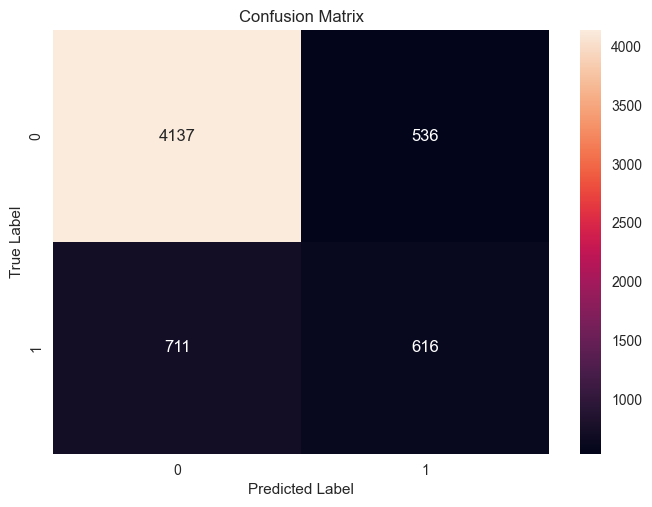


=== Train Metrics ===
     Model  precision_score  recall_score  f1_score  accuracy  roc_auc
class_LGBM           0.9909        0.9905    0.9906    0.9905   0.9999

=== Test Metrics ===
     Model  precision_score  recall_score  f1_score  accuracy  roc_auc
class_LGBM           0.7829        0.7922    0.7867    0.7922   0.7540

Search took 355.69 seconds.


In [ ]:
# LightGBM model tuning and evaluation

X_train_log = pd.read_csv("../data/processed/X_train_log.csv").values
X_test_log = pd.read_csv("../data/processed/X_test_log.csv").values
y_train = pd.read_csv("../data/processed/y_train_scaled.csv").values.flatten()
y_test = pd.read_csv("../data/processed/y_test_scaled.csv").values.flatten()


model = LGBMClassifier(random_state=SEED, n_jobs=-1, verbose=-1)

model_name = "class_LGBM"
start = time.time()

param_grid = {
    "n_estimators": [500, 800, 1000],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "max_depth": [4, 6, 8, 10, -1],
    "num_leaves": [15, 31, 63],
    "min_child_samples": [10, 20, 30],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0],
    "reg_alpha": [0.0, 0.1, 0.5],
    "reg_lambda": [0.0, 0.1, 0.5],
    "class_weight": ["balanced"],
}

n_iter = 150

best_model = model_tuning(model, param_grid, n_iter, X_train_log, y_train)
evaluate_tuned(best_model, X_train_log, y_train, X_test_log, y_test, model_name)

print("\nSearch took %.2f seconds." % (time.time() - start))

filename = f"{model_name}.sav"
pickle.dump(best_model, open(f"../models/{filename}", "wb"))

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best Parameters: {'subsample': 0.8, 'random_strength': 5, 'learning_rate': 0.05, 'l2_leaf_reg': 2, 'iterations': 1000, 'depth': 10, 'bootstrap_type': 'Bernoulli', 'auto_class_weights': 'Balanced'}

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      4673
           1       0.54      0.49      0.51      1327

    accuracy                           0.79      6000
   macro avg       0.70      0.68      0.69      6000
weighted avg       0.79      0.79      0.79      6000



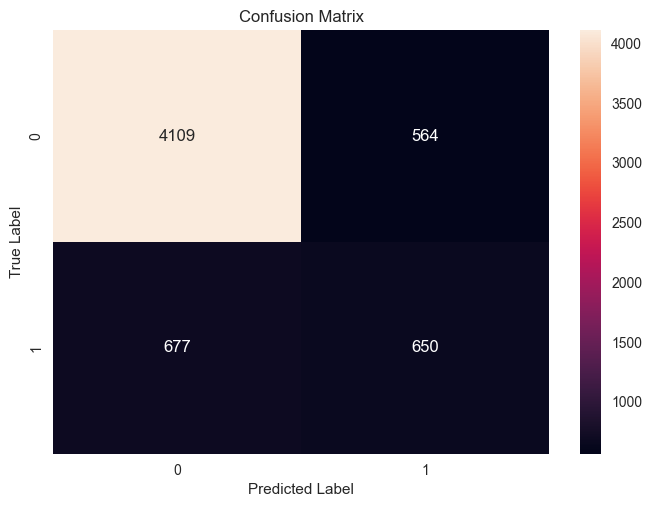


=== Train Metrics ===
         Model  precision_score  recall_score  f1_score  accuracy  roc_auc
class_CatBoost           0.9821        0.9808    0.9811    0.9808   0.9992

=== Test Metrics ===
         Model  precision_score  recall_score  f1_score  accuracy  roc_auc
class_CatBoost           0.7871        0.7932    0.7898    0.7932   0.7543

Search took 4083.97 seconds.


In [ ]:
# CatBoost model tuning and evaluation


X_train_log = pd.read_csv("../data/processed/X_train_log.csv").values
X_test_log = pd.read_csv("../data/processed/X_test_log.csv").values
y_train = pd.read_csv("../data/processed/y_train_scaled.csv").values.flatten()
y_test = pd.read_csv("../data/processed/y_test_scaled.csv").values.flatten()


model = CatBoostClassifier(
    verbose=0,
    random_state=SEED,
    early_stopping_rounds=50,
    auto_class_weights="Balanced",
)

model_name = "class_CatBoost"
start = time.time()

param_grid = {
    "iterations": [500, 800, 1000],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "depth": [4, 6, 8, 10],
    "l2_leaf_reg": [1, 2, 3, 5, 10],
    "subsample": [0.8, 0.9, 1.0],  # Boosting with or without sampling
    "random_strength": [1, 5, 10],  # Randomness in scoring splits
    "bootstrap_type": ["Bernoulli", "MVS"],
    "auto_class_weights": ["Balanced"],
}


n_iter = 150

best_model = model_tuning(model, param_grid, n_iter, X_train_log, y_train)
evaluate_tuned(best_model, X_train_log, y_train, X_test_log, y_test, model_name)

print("\nSearch took %.2f seconds." % (time.time() - start))

filename = f"{model_name}.sav"
pickle.dump(best_model, open(f"../models/{filename}", "wb"))

No point tuning a noisy model. Clean features → smaller models → better generalization.

# Additional Data Engineering

## SHAP & BorutaPy Feature Selection

In [ ]:
# BorutaPy for classification on not log-transformed data

X_train = pd.read_csv("../data/processed/X_train_scaled.csv").values
X_test = pd.read_csv("../data/processed/X_test_scaled.csv").values
y_train = pd.read_csv("../data/processed/y_train_scaled.csv").values.flatten()
y_test = pd.read_csv("../data/processed/y_test_scaled.csv").values.flatten()
feature_names = X_train.columns


def run_boruta_feature_selection(X, y, feature_names):
    """
    Perform feature selection using the Boruta algorithm.

    Args:
        X (np.ndarray): Training feature matrix.
        y (np.ndarray): Training labels.
        feature_names (list or Index): Feature names.

    Returns:
        pd.DataFrame: DataFrame showing feature importance ranking and selection.
    """
    model = RandomForestClassifier(random_state=SEED)
    selector = BorutaPy(
        estimator=model, n_estimators="auto", verbose=-2, random_state=SEED
    )
    selector.fit(X, y)

    results_df = pd.DataFrame(
        {
            "Feature": feature_names,
            "Ranking": selector.ranking_,
            "Selected": selector.support_,
        }
    )

    return results_df.sort_values(by="Ranking")


# Run Boruta and display results
selected_features_df = run_boruta_feature_selection(X_train, y_train, feature_names)

print("Selected Features by BorutaPy:")
print(selected_features_df)

Selected Features by BorutaPy:
           Feature  Ranking  Selected
5            PAY_0        1      True
6            PAY_2        1      True
11       BILL_AMT1        2     False
17        PAY_AMT1        3     False
7            PAY_3        4     False
12       BILL_AMT2        5     False
4              AGE        6     False
0        LIMIT_BAL        7     False
18        PAY_AMT2        8     False
13       BILL_AMT3        9     False
19        PAY_AMT3       10     False
16       BILL_AMT6       11     False
15       BILL_AMT5       11     False
14       BILL_AMT4       13     False
22        PAY_AMT6       14     False
8            PAY_4       15     False
20        PAY_AMT4       16     False
21        PAY_AMT5       16     False
9            PAY_5       18     False
10           PAY_6       19     False
23  LIMIT_BAL_bins       20     False
24        AGE_bins       21     False
2        EDUCATION       22     False
3         MARRIAGE       23     False
1              SEX 

 99%|===================| 23871/24000 [00:57<00:00]        

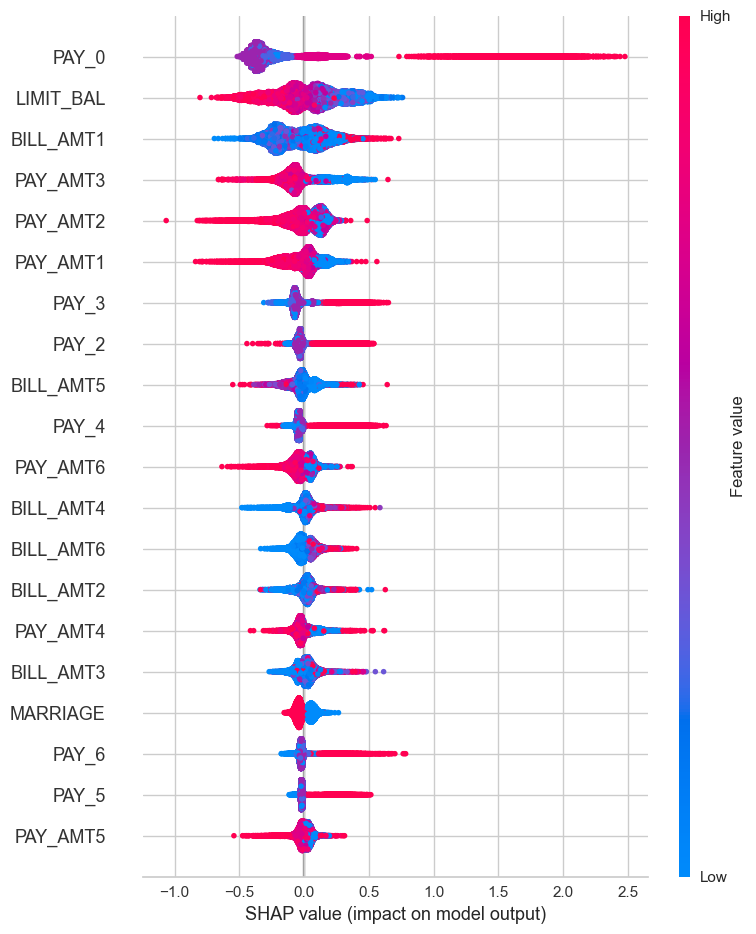

In [ ]:
# SHAP on scaled and log-transformed data

X_train_log = pd.read_csv("../data/processed/X_train_scaled.csv").values
X_test_log = pd.read_csv("../data/processed/X_test_scaled.csv").values
y_train = pd.read_csv("../data/processed/y_train_scaled.csv").values.flatten()
y_test = pd.read_csv("../data/processed/y_test_scaled.csv").values.flatten()



def plot_shap_summary(X_train, y_train, feature_names):
    """Plot SHAP summary using LightGBM for speed."""
    model = LGBMClassifier(random_state=SEED, n_jobs=-1, verbose=-1)
    model.fit(X_train, y_train)
    explainer = shap.Explainer(model, X_train)  # Uses TreeExplainer under the hood
    shap_values = explainer(X_train)
    shap.summary_plot(
        shap_values, features=X_train, feature_names=feature_names, rng=SEED
    )



plot_shap_summary(X_train_log, y_train, feature_names)

* Purpose: Understand feature influence globally.
* Outcome: Confirmed importance of PAY_0, LIMIT_BAL, BILL_AMT1, PAY_AMT1–3.

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best Parameters: {'subsample': 0.85, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'num_leaves': 60, 'n_estimators': 200, 'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.8, 'class_weight': 'balanced'}

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      4673
           1       0.51      0.52      0.52      1327

    accuracy                           0.78      6000
   macro avg       0.69      0.69      0.69      6000
weighted avg       0.79      0.78      0.78      6000



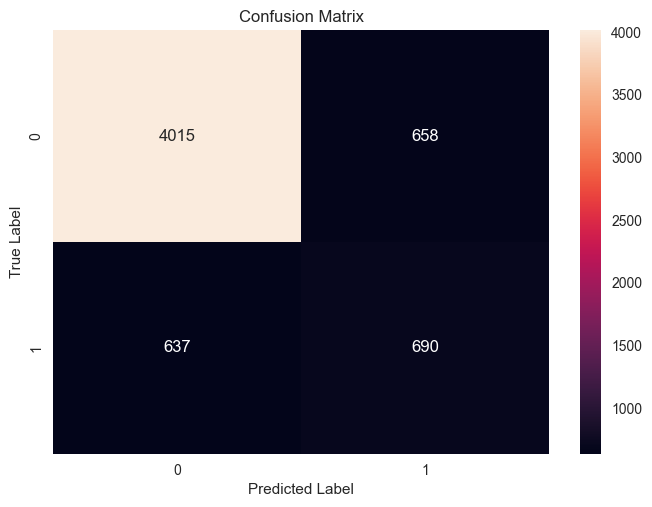


=== Train Metrics ===
     Model  precision_score  recall_score  f1_score  accuracy  roc_auc
class_LGBM           0.7893        0.7859    0.7875    0.7859   0.7458

=== Test Metrics ===
     Model  precision_score  recall_score  f1_score  accuracy  roc_auc
class_LGBM           0.7854        0.7842    0.7848    0.7842   0.7419

Search took 28.73 seconds.


In [ ]:
# LightGBM model tuning and evaluation with Boruta

# Create Botura set:
X_train_log_boruta = pd.read_csv("../data/processed/X_train_log.csv")[["PAY_0", "PAY_2", "BILL_AMT1"]]
X_test_log_boruta = pd.read_csv("../data/processed/X_test_log.csv")[["PAY_0", "PAY_2", "BILL_AMT1"]]
y_train = pd.read_csv("../data/processed/y_train_scaled.csv")
y_test = pd.read_csv("../data/processed/y_test_scaled.csv")


model = LGBMClassifier(random_state=SEED, n_jobs=-1, verbose=-1)

model_name = "class_LGBM"
start = time.time()

param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.005, 0.01, 0.015],
    "max_depth": [3, 4, 5],
    "num_leaves": [40, 60, 80, 100],
    "min_child_samples": [5, 10, 15, 20],
    "subsample": [0.7, 0.85, 0.9, 0.95],
    "colsample_bytree": [0.8, 0.9, 1.0],
    "reg_alpha": [0.0, 0.05, 0.1, 0.2],
    "reg_lambda": [0.0, 0.05, 0.1],
    "class_weight": ["balanced"]
}


n_iter = 150

best_model = model_tuning(model, param_grid, n_iter, X_train_log_boruta, y_train)
evaluate_tuned(best_model, X_train_log_boruta, y_train, X_test_log_boruta, y_test, model_name)

print("\nSearch took %.2f seconds." % (time.time() - start))

filename = f"{model_name}_Boruta.sav"
pickle.dump(best_model, open(f"../models/{filename}", "wb"))

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best Parameters: {'subsample': 1.0, 'random_strength': 10, 'learning_rate': 0.01, 'l2_leaf_reg': 1, 'iterations': 800, 'depth': 8, 'bootstrap_type': 'Bernoulli', 'auto_class_weights': 'Balanced'}

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      4673
           1       0.50      0.52      0.51      1327

    accuracy                           0.78      6000
   macro avg       0.68      0.69      0.69      6000
weighted avg       0.78      0.78      0.78      6000



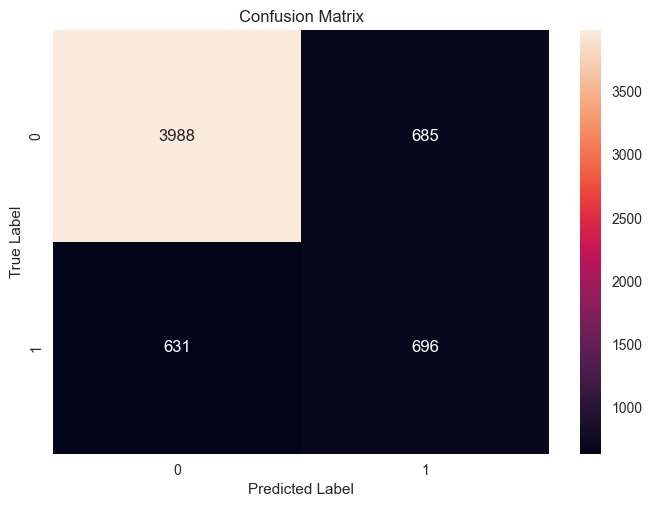


=== Train Metrics ===
         Model  precision_score  recall_score  f1_score  accuracy  roc_auc
class_CatBoost           0.7881        0.7826    0.7852    0.7826   0.7536

=== Test Metrics ===
         Model  precision_score  recall_score  f1_score  accuracy  roc_auc
class_CatBoost           0.7839        0.7807    0.7822    0.7807   0.7482

Search took 1621.47 seconds.


In [ ]:
# CatBoost model tuning and evaluation with Boruta

# Create Botura set:
X_train_log_boruta = pd.read_csv("../data/processed/X_train_log.csv")[["PAY_0", "PAY_2", "BILL_AMT1"]]
X_test_log_boruta = pd.read_csv("../data/processed/X_test_log.csv")[["PAY_0", "PAY_2", "BILL_AMT1"]]
y_train = pd.read_csv("../data/processed/y_train_scaled.csv")
y_test = pd.read_csv("../data/processed/y_test_scaled.csv")

model = CatBoostClassifier(
    verbose=0,
    random_state=SEED,
    early_stopping_rounds=50,
    auto_class_weights="Balanced",
)

model_name = "class_CatBoost"
start = time.time()

param_grid = {
    "iterations": [500, 800, 1000],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "depth": [4, 6, 8, 10],
    "l2_leaf_reg": [1, 2, 3, 5, 10],
    "subsample": [0.8, 0.9, 1.0],  # Boosting with or without sampling
    "random_strength": [1, 5, 10],  # Randomness in scoring splits
    "bootstrap_type": ["Bernoulli", "MVS"],
    "auto_class_weights": ["Balanced"],
}


n_iter = 150

best_model = model_tuning(model, param_grid, n_iter, X_train_log_boruta, y_train)
evaluate_tuned(best_model, X_train_log_boruta, y_train, X_test_log_boruta, y_test, model_name)

print("\nSearch took %.2f seconds." % (time.time() - start))

filename = f"{model_name}_Boruta.sav"
pickle.dump(best_model, open(f"../models/{filename}", "wb"))

* Features: PAY_0, PAY_2, BILL_AMT1 turned out to be the most important features by BorutaPy. BILL_AMT1 addition to the 1st ranked improved ROC AUC score.
* Further addition of features haven't yelded good results.
* Lightweight and interpretable set with solid performance, excellent for comparison or low-complexity deployments. Boruta-only is precise and stable, but misses some deeper signals (lower AUC).

## VIF

In [ ]:
def calculate_vif(dataframe):
    """
    Calculate Variance Inflation Factor (VIF) for each numeric feature in the DataFrame.

    Args:
        dataframe (pd.DataFrame): DataFrame containing numeric features.

    Returns:
        pd.DataFrame: A DataFrame with feature names and their corresponding VIF values.
    """
    vif_data = pd.DataFrame()
    vif_data["feature"] = dataframe.columns
    vif_data["VIF"] = [
        variance_inflation_factor(dataframe.values, i)
        for i in range(dataframe.shape[1])
    ]
    return vif_data


# Load preprocessed dataset
df_prep = pd.read_csv("../data/processed/df_prep.csv")

# Columns to drop: engineered bins and the target variable
columns_to_drop = ["LIMIT_BAL_bins", "AGE_bins", "default.payment.next.month"]

# Select only numeric columns, excluding the ones to drop
numeric_columns = (
    df_prep.drop(columns=columns_to_drop).select_dtypes(include="number").columns
)
df_numeric_only = df_prep[numeric_columns]

# Calculate and print VIF results
vif_result = calculate_vif(df_numeric_only)
print("Variance Inflation Factors:")
print(vif_result)

Variance Inflation Factors:
      feature        VIF
0   LIMIT_BAL   4.045042
1         SEX   9.138316
2   EDUCATION   7.404015
3    MARRIAGE   6.353580
4         AGE  11.155951
5       PAY_0   1.918283
6       PAY_2   3.211462
7       PAY_3   3.727665
8       PAY_4   4.440211
9       PAY_5   4.985794
10      PAY_6   3.463773
11  BILL_AMT1  20.822611
12  BILL_AMT2  38.215095
13  BILL_AMT3  31.782841
14  BILL_AMT4  29.548014
15  BILL_AMT5  35.988395
16  BILL_AMT6  21.425905
17   PAY_AMT1   1.907550
18   PAY_AMT2   2.384864
19   PAY_AMT3   1.911650
20   PAY_AMT4   1.805061
21   PAY_AMT5   1.854268
22   PAY_AMT6   1.270652


VIF>10 is treated as high multicolinearity.

Possible actions:

* Ignore
* Throw out predictors
* Pool predictors
* Structural multicolinearity
* Penalized regression
* Specification errors

Outcome: High VIFs in BILL_AMT series, especially BILL_AMT2–5

Justifies PCA usage and dropping redundant features

## PCA Feature Compression

In [ ]:
# # Load scaled and log-transformed training and test sets
X_train_log = pd.read_csv("../data/processed/X_train_log.csv")
X_test_log = pd.read_csv("../data/processed/X_test_log.csv")
y_train = pd.read_csv("../data/processed/y_train_scaled.csv")
y_test = pd.read_csv("../data/processed/y_test_scaled.csv")

# Define feature groups and PCA component count
bill_features = [
    "BILL_AMT1",
    "BILL_AMT2",
    "BILL_AMT3",
    "BILL_AMT4",
    "BILL_AMT5",
    "BILL_AMT6",
]
amt_features = ["PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]
n_components_bill = 2
n_components_amt = 4

# --- PCA for BILL_AMT features ---
pca_bill = PCA(n_components=n_components_bill, random_state=SEED)
X_train_pca_bill = pd.DataFrame(
    pca_bill.fit_transform(X_train_log[bill_features]),
    columns=[f"PCA_BILL_{i + 1}" for i in range(n_components_bill)],
    index=X_train_log.index,
)
X_test_pca_bill = pd.DataFrame(
    pca_bill.transform(X_test_log[bill_features]),
    columns=[f"PCA_BILL_{i + 1}" for i in range(n_components_bill)],
    index=X_test_log.index,
)

# --- PCA for PAY_AMT features ---
pca_amt = PCA(n_components=n_components_amt, random_state=SEED)
X_train_pca_amt = pd.DataFrame(
    pca_amt.fit_transform(X_train_log[amt_features]),
    columns=[f"PCA_AMT_{i + 1}" for i in range(n_components_amt)],
    index=X_train_log.index,
)
X_test_pca_amt = pd.DataFrame(
    pca_amt.transform(X_test_log[amt_features]),
    columns=[f"PCA_AMT_{i + 1}" for i in range(n_components_amt)],
    index=X_test_log.index,
)

# Display explained variance for both PCA applications
print("Explained Variance Ratios (BILL_AMT):", pca_bill.explained_variance_ratio_)
print("Explained Variance Ratios (PAY_AMT):", pca_amt.explained_variance_ratio_)

# Drop original features replaced by PCA
drop_columns = bill_features + amt_features + ["LIMIT_BAL_bins", "AGE_bins"]
X_train_log_pca = X_train_log.drop(columns=drop_columns)
X_test_log_pca = X_test_log.drop(columns=drop_columns)



X_train_log_pca.columns = [col.replace(' ', '_') for col in X_train_log_pca.columns]
X_test_log_pca.columns = [col.replace(' ', '_') for col in X_test_log_pca.columns]


# Add PCA features into final datasets
X_train_log_pca = pd.concat(
    [X_train_log_pca, X_train_pca_bill, X_train_pca_amt], axis=1
)
X_test_log_pca = pd.concat([X_test_log_pca, X_test_pca_bill, X_test_pca_amt], axis=1)

Explained Variance Ratios (BILL_AMT): [0.90823308 0.05081671]
Explained Variance Ratios (PAY_AMT): [0.5313358  0.11736668 0.09755813 0.09132695]


Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best Parameters: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.0, 'num_leaves': 63, 'n_estimators': 800, 'min_child_samples': 10, 'max_depth': -1, 'learning_rate': 0.05, 'colsample_bytree': 1.0, 'class_weight': 'balanced'}

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      4673
           1       0.51      0.52      0.52      1327

    accuracy                           0.79      6000
   macro avg       0.69      0.69      0.69      6000
weighted avg       0.79      0.79      0.79      6000



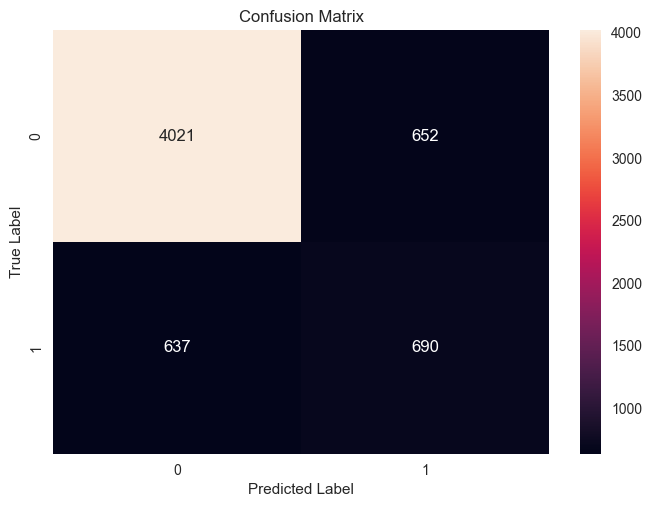


=== Train Metrics ===
     Model  precision_score  recall_score  f1_score  accuracy  roc_auc
class_LGBM           0.9690        0.9655    0.9662    0.9655   0.9970

=== Test Metrics ===
     Model  precision_score  recall_score  f1_score  accuracy  roc_auc
class_LGBM           0.7860        0.7852    0.7856    0.7852   0.7586

Search took 309.75 seconds.


In [ ]:
# LightGBM model tuning and evaluation with PCA

model = LGBMClassifier(random_state=SEED, n_jobs=-1, verbose=-1)

model_name = "class_LGBM"
start = time.time()

param_grid = {
    "n_estimators": [500, 800, 1000],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "max_depth": [4, 6, 8, 10, -1],
    "num_leaves": [15, 31, 63],
    "min_child_samples": [10, 20, 30],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0],
    "reg_alpha": [0.0, 0.1, 0.5],
    "reg_lambda": [0.0, 0.1, 0.5],
    "class_weight": ["balanced"],
}

n_iter = 150

best_model = model_tuning(model, param_grid, n_iter, X_train_log_pca, y_train)
evaluate_tuned(best_model, X_train_log_pca, y_train, X_test_log_pca, y_test, model_name)

print("\nSearch took %.2f seconds." % (time.time() - start))

filename = f"{model_name}_PCA.sav"
pickle.dump(best_model, open(f"../models/{filename}", "wb"))

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best Parameters: {'subsample': 0.9, 'random_strength': 10, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 1000, 'depth': 10, 'bootstrap_type': 'Bernoulli', 'auto_class_weights': 'Balanced'}

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      4673
           1       0.54      0.46      0.49      1327

    accuracy                           0.79      6000
   macro avg       0.69      0.67      0.68      6000
weighted avg       0.78      0.79      0.79      6000



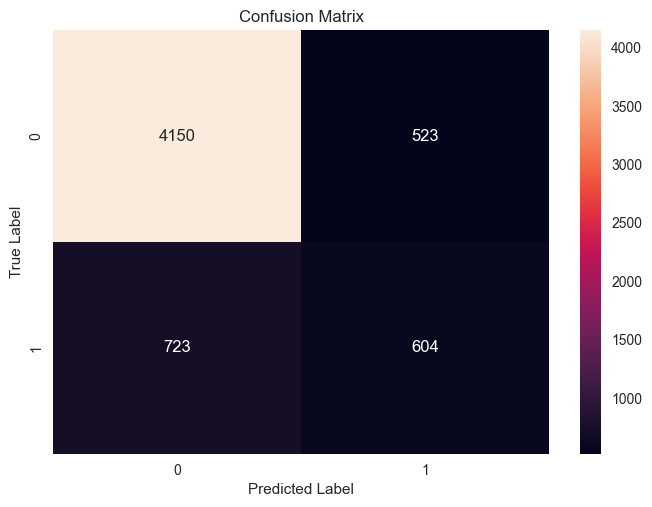


=== Train Metrics ===
         Model  precision_score  recall_score  f1_score  accuracy  roc_auc
class_CatBoost           0.9968        0.9967    0.9967    0.9967   1.0000

=== Test Metrics ===
         Model  precision_score  recall_score  f1_score  accuracy  roc_auc
class_CatBoost           0.7818        0.7923    0.7860    0.7923   0.7405

Search took 2925.90 seconds.


In [ ]:
# CatBoost model tuning and evaluation with PCA

model = CatBoostClassifier(
    verbose=0,
    random_state=SEED,
    early_stopping_rounds=50,
    auto_class_weights="Balanced",
)

model_name = "class_CatBoost"
start = time.time()

param_grid = {
    "iterations": [500, 800, 1000],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "depth": [4, 6, 8, 10],
    "l2_leaf_reg": [1, 2, 3, 5, 10],
    "subsample": [0.8, 0.9, 1.0],  # Boosting with or without sampling
    "random_strength": [1, 5, 10],  # Randomness in scoring splits
    "bootstrap_type": ["Bernoulli", "MVS"],
    "auto_class_weights": ["Balanced"],
}


n_iter = 150

best_model = model_tuning(model, param_grid, n_iter, X_train_log_pca, y_train)
evaluate_tuned(best_model, X_train_log_pca, y_train, X_test_log_pca, y_test, model_name)

print("\nSearch took %.2f seconds." % (time.time() - start))

filename = f"{model_name}_PCA.sav"
pickle.dump(best_model, open(f"../models/{filename}", "wb"))

* Features: All original features except BILL_AMT*, PAY_AMT*, replaced with 6 PCA components.

## Summary

Boruta helped reduce dimensionality but slightly dropped performance.

PCA preserved performance while simplifying features—solid middle ground.

CatBoost is robust but expensive computationally.

---
 Hyperparameter tuning was explored for optimization but did not yield substantial improvements. Default settings of LGBM and CatBoost are optimized for general use cases and often provide good performance without extensive tuning.


# NN

In [40]:
def evaluate_nn(
    preds_proba_train,
    preds_train,
    preds_proba_test,
    preds_test,
    y_train,
    y_test,
    model_name,
):
    """
    Evaluate a trained neural network classifier using various metrics.

    This function computes weighted precision, recall, F1 score, accuracy, and
    ROC-AUC for both training and test sets. It also displays a classification
    report and confusion matrix.

    Args:
        preds_proba_train (ndarray): Predicted probabilities on training data.
        preds_train (ndarray): Predicted class labels on training data.
        preds_proba_test (ndarray): Predicted probabilities on test data.
        preds_test (ndarray): Predicted class labels on test data.
        y_train (ndarray): Ground truth labels for training set.
        y_test (ndarray): Ground truth labels for test set.
        model_name (str): Name of the evaluated model.
    """
    metrics = [precision_score, recall_score, f1_score]
    scores_train = []
    scores_test = []

    model_scores_train = {"Model": model_name}
    model_scores_test = {"Model": model_name}

    # Compute evaluation metrics for both train and test sets
    for metric in metrics:
        model_scores_train[metric.__name__] = metric(
            y_train,
            preds_train,
            average="weighted",
            zero_division=0,
        )
        model_scores_test[metric.__name__] = metric(
            y_test,
            preds_test,
            average="weighted",
            zero_division=0,
        )

    model_scores_train["accuracy"] = accuracy_score(y_train, preds_train)
    model_scores_test["accuracy"] = accuracy_score(y_test, preds_test)

    # ROC-AUC for multiclass classification
    model_scores_train["roc_auc"] = roc_auc_score(y_train, preds_proba_train)
    model_scores_test["roc_auc"] = roc_auc_score(y_test, preds_proba_test)

    scores_train.append(model_scores_train)
    scores_test.append(model_scores_test)

    # Classification report for test set
    print("\n=== Classification Report ===")
    print(classification_report(y_test, preds_test))

    # Confusion matrix plot
    conf_matrix = confusion_matrix(y_test, preds_test)
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt=".0f",
        xticklabels=np.unique(y_test),
        yticklabels=np.unique(y_test),
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Display metric results
    results_df_train = pd.DataFrame(scores_train)
    results_df_test = pd.DataFrame(scores_test)

    print("\n=== Train Metrics ===")
    print(results_df_train.to_string(index=False, float_format="%.4f"))

    print("\n=== Test Metrics ===")
    print(results_df_test.to_string(index=False, float_format="%.4f"))

In [125]:
def plot_history(history):
    """
    Plot training history of accuracy and loss.

    Args:
        history (History): Keras History object from model.fit().
    """
    print(history.history.keys())
    print()

    # F1Score
    plt.plot(history.history['F1Score'], color="salmon")
    plt.plot(history.history['val_F1Score'], color="sienna")
    plt.title('Model F1Score')
    plt.ylabel('F1Score')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # Loss
    plt.plot(history.history['loss'], color="salmon")
    plt.plot(history.history['val_loss'], color="sienna")
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [ ]:
strat_train_set = pd.read_csv("../data/processed/strat_train_set.csv")
strat_test_set = pd.read_csv("../data/processed/strat_test_set.csv")
strat_train_set, strat_val_set, feature_names = stratify_splitting(strat_train_set, "default.payment.next.month")

strat_train_set_log, strat_test_set_log = log_transform_skewed_features_safe(
    strat_train_set, strat_test_set
)
strat_train_set_log, strat_val_set_log = log_transform_skewed_features_safe(
    strat_train_set, strat_val_set
)
X_train_log, y_train, X_test_log, y_test = xy_splitting_scaling(
    strat_train_set_log, strat_test_set_log, "default.payment.next.month", feature_names
)
X_train_log, y_train, X_val_log, y_val = xy_splitting_scaling(
    strat_train_set_log, strat_val_set_log, "default.payment.next.month", feature_names
)

Log-transforming these skewed columns: ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
Skipping 'BILL_AMT1' due to values <= -1 that break log1p.
Skipping 'BILL_AMT2' due to values <= -1 that break log1p.
Skipping 'BILL_AMT3' due to values <= -1 that break log1p.
Skipping 'BILL_AMT4' due to values <= -1 that break log1p.
Skipping 'BILL_AMT5' due to values <= -1 that break log1p.
Skipping 'BILL_AMT6' due to values <= -1 that break log1p.
Log-transforming these skewed columns: ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
Skipping 'BILL_AMT1' due to values <= -1 that break log1p.
Skipping 'BILL_AMT2' due to values <= -1 that break log1p.
Skipping 'BILL_AMT3' due to values <= -1 that break log1p.
Skipping 'BILL_AMT4' due to values <= -1 that break log1p.
Skipping 'BILL_AMT5' due to va


Epoch 272: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 295: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
Epoch 302: early stopping
Restoring model weights from the end of the best epoch: 287.
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - F1Score: 0.3706 - loss: 0.4488


dict_keys(['F1Score', 'loss', 'val_F1Score', 'val_loss', 'learning_rate'])

dict_keys(['F1Score', 'loss', 'val_F1Score', 'val_loss', 'learning_rate'])



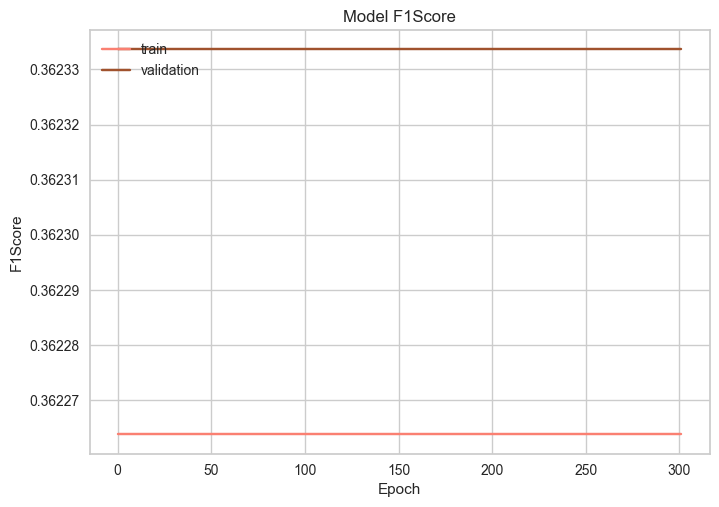

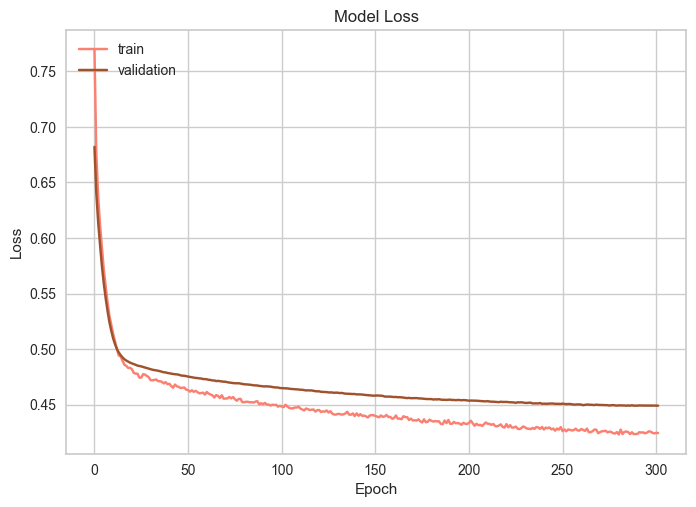


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.66      0.36      0.46      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.65      0.68      6000
weighted avg       0.80      0.82      0.80      6000



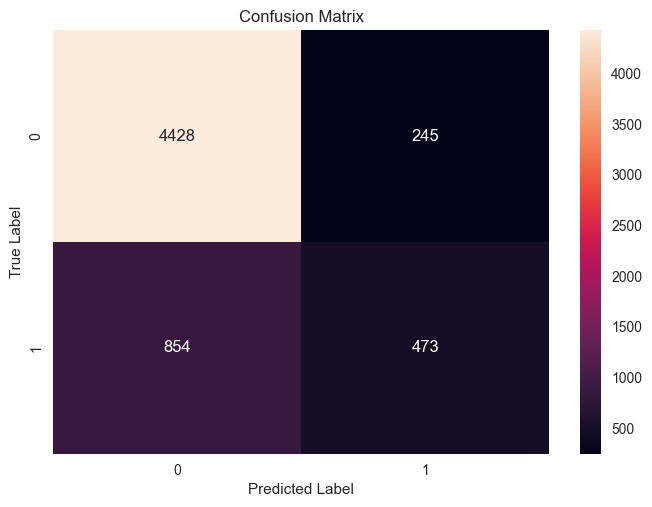


=== Train Metrics ===
Model  precision_score  recall_score  f1_score  accuracy  roc_auc
   NN           0.8138        0.8280    0.8079    0.8280   0.8072

=== Test Metrics ===
Model  precision_score  recall_score  f1_score  accuracy  roc_auc
   NN           0.7986        0.8168    0.7952    0.8168   0.7690


In [ ]:
# Define model architecture
input_dim = X_train_log.shape[1]

model = tf.keras.Sequential([
    Input(shape=(input_dim,)),

    tf.keras.layers.Dense(64),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.05),

    tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.05),
    
    tf.keras.layers.Dense(1, activation="sigmoid")
])


# Compile model with AdamW optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.00005,  # more conservative
    weight_decay=1e-5
)

model.compile(
    optimizer=optimizer,
    metrics=["F1Score"],
    loss="binary_crossentropy"
)


# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor="val_loss", verbose=1, patience=15, restore_best_weights=True
)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, verbose=1)

# Train model
history = model.fit(
    X_train_log,
    y_train,
    validation_data=(X_val_log, y_val),
    batch_size=64,
    epochs=1000,
    verbose=0,
    callbacks=[early_stopping, lr_scheduler],
)

# Predict probabilities
preds_proba_train = model.predict(X_train_log)
# Convert probabilities to class labels
preds_train = (preds_proba_train > 0.5).astype(int).flatten()

# Predict probabilities
preds_proba_test = model.predict(X_test_log)
# Convert probabilities to class labels
preds_test = (preds_proba_test > 0.5).astype(int).flatten()

# Evaluate model on test set
model.evaluate(X_test_log, y_test)

model.save("../models/NNmodel.h5")


model_name = "NN"


# Plotting models MAPE and los during training
df_history = pd.DataFrame(history.history)

# list all data in history
print(history.history.keys())
print()

# Plot training history
plot_history(history)


# Evaluate predictions
evaluate_nn(
    preds_proba_train,
    preds_train,
    preds_proba_test,
    preds_test,
    y_train,
    y_test,
    model_name,
)

In [36]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,101 (47.27 KB)

 Trainable params: 3,969 (15.50 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 7,940 (31.02 KB)

Neural Network outperformed all with higher generalization and best metrics.

Best Test F1, best AUC, best accuracy

Consistent generalization (no overfitting)

# Conclusion

This project demonstrated a thorough evaluation of various classification models and preprocessing strategies to predict credit card default. Among all tested approaches, a neural network trained on log-transformed and scaled data achieved the best overall performance. 